# Classifaction prediction of corporate ESG Ratings based on Fortune 1000 company data

From natural resource scarcity to changing governance standards, from global
workforce management to the evolving regulatory landscape, ESG factors can affect
the long-term risk-and-return profile of investment portfolios. MSCI ESG Ratings are
designed to help investors understand ESG risks and opportunities and integrate these
factors into their portfolio construction and management process.

**MSCI ESG Ratings Methodology Overview**

MSCI ESG Ratings aim to measure a company’s resilience to long-term,
financially relevant ESG risks.
- Of the negative externalities that companies in an industry generate, which
issues may turn into unanticipated costs for companies in the medium to longterm?
- Conversely, which ESG issues affecting an industry may turn into opportunities for companies in the medium to long-term? More specifically, the MSCI ESG Ratings model seeks to answer four key uestions about companies:
 - What are the most significant ESG risks and opportunities facing a companyand its industry?
 - How exposed is the company to those key risks and/or opportunities?
 - How well is the company managing key risks and/or opportunities?
 - What is the overall picture of a company and how does it compare to itsglobal industry peers?

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve


from pandasql import sqldf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
import xgboost


from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
ls

Working_Notebook.ipynb      Working_Notebook_EDA.ipynb


In [3]:
F1_000_df = pd.read_csv('../Data/Fortune_1000.csv')

In [4]:
F1_000_df.head()

company  rank  rank_change   revenue   profit  num. of employees  \
0      Walmart     1          0.0  523964.0  14881.0            2200000   
1       Amazon     2          3.0  280522.0  11588.0             798000   
2  Exxon Mobil     3         -1.0  264938.0  14340.0              74900   
3        Apple     4         -1.0  260174.0  55256.0             137000   
4   CVS Health     5          3.0  256776.0   6634.0             290000   

        sector         city state newcomer ceo_founder ceo_woman profitable  \
0    Retailing  Bentonville    AR       no          no        no        yes   
1    Retailing      Seattle    WA       no         yes        no        yes   
2       Energy       Irving    TX       no          no        no        yes   
3   Technology    Cupertino    CA       no          no        no        yes   
4  Health Care   Woonsocket    RI       no          no       yes        yes   

  prev_rank                  CEO                        Website Ticker  \
0       1.0  C. Douglas McMillon  https://www.stock.walmart.com    WMT   
1       5.0     Jeffrey P. Bezos         https://www.amazon.com   AMZN   
2       2.0      Darren W. Woods     https://www.exxonmobil.com    XOM   
3       3.0      Timothy D. Cook          https://www.apple.com   AAPL   
4       8.0       Karen S. Lynch      https://www.cvshealth.com    CVS   

  Market Cap  
0     411690  
1    1637405  
2     177923  
3    2221176  
4      98496

In [5]:
esg_info_df = pd.read_csv('../Data/MSCI_esg.csv')

In [6]:
esg_info_df.head()

Company Name Ticker Country  \
0            0921706 BC LTD    NaN      CA   
1  1 MADISON OFFICE FEE LLC    NaN      US   
2                    1&1 AG    1U1      DE   
3     1-800-FLOWERSCOM, INC   FLWS      US   
4           1000 AUAHI, LLC    NaN      US   

                                             Sector  \
0                        Telecommunication Services   
1                 Real Estate Management & Services   
2                        Telecommunication Services   
3                   Retail - Consumer Discretionary   
4  Real Estate Development & Diversified Activities   

                             Subsector Overall ESG RATING  Overall ESG SCORE  \
0  Wireless Telecommunication Services                  A                6.6   
1                         Office REITs                BBB                4.7   
2  Wireless Telecommunication Services                  B                2.0   
3   Internet & Direct Marketing Retail                BBB                5.6   
4              Real Estate Development                  A                6.8   

   Environmental SCORE  Social SCORE  Governance SCORE  
0                 10.0           7.4               2.7  
1                  8.5           5.8               2.6  
2                  7.8           3.3               4.4  
3                  1.2           6.7               3.8  
4                  6.1           4.1               6.9

### Initial Data Cleaning

In [7]:
F1_000_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company            1000 non-null   object 
 1   rank               1000 non-null   int64  
 2   rank_change        1000 non-null   float64
 3   revenue            1000 non-null   float64
 4   profit             998 non-null    float64
 5   num. of employees  1000 non-null   int64  
 6   sector             1000 non-null   object 
 7   city               1000 non-null   object 
 8   state              1000 non-null   object 
 9   newcomer           500 non-null    object 
 10  ceo_founder        1000 non-null   object 
 11  ceo_woman          1000 non-null   object 
 12  profitable         1000 non-null   object 
 13  prev_rank          1000 non-null   object 
 14  CEO                992 non-null    object 
 15  Website            1000 non-null   object 
 16  Ticker             938 no

In [8]:
F1_000_df.isna().sum()

company                0
rank                   0
rank_change            0
revenue                0
profit                 2
num. of employees      0
sector                 0
city                   0
state                  0
newcomer             500
ceo_founder            0
ceo_woman              0
profitable             0
prev_rank              0
CEO                    8
Website                0
Ticker                62
Market Cap            40
dtype: int64

In [9]:
esg_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15646 entries, 0 to 15645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company Name         15646 non-null  object 
 1   Ticker               10441 non-null  object 
 2   Country              15644 non-null  object 
 3   Sector               15646 non-null  object 
 4   Subsector            14860 non-null  object 
 5   Overall ESG RATING   15646 non-null  object 
 6   Overall ESG SCORE    15646 non-null  float64
 7   Environmental SCORE  15646 non-null  float64
 8   Social SCORE         15646 non-null  float64
 9   Governance SCORE     15646 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.2+ MB


In [10]:
esg_info_df.isna().sum()

Company Name              0
Ticker                 5205
Country                   2
Sector                    0
Subsector               786
Overall ESG RATING        0
Overall ESG SCORE         0
Environmental SCORE       0
Social SCORE              0
Governance SCORE          0
dtype: int64

esg_info column names

In [11]:
esg_info_df.columns

Index(['Company Name', 'Ticker', 'Country', 'Sector', 'Subsector',
       'Overall ESG RATING', 'Overall ESG SCORE', 'Environmental SCORE',
       'Social SCORE', 'Governance SCORE'],
      dtype='object')

In [12]:
esg_info_df.rename(columns=lambda x: x.lower(), inplace=True)
esg_info_df.columns = esg_info_df.columns.str.replace(' ','_')

# Same for F1000
F1_000_df.rename(columns=lambda x: x.lower(), inplace=True)
F1_000_df.columns = F1_000_df.columns.str.replace(' ','_')
F1_000_df.rename(columns = {'num._of_employees':'num_of_employees'}, inplace = True)

In [13]:
F1_000_df.head()

company  rank  rank_change   revenue   profit  num_of_employees  \
0      Walmart     1          0.0  523964.0  14881.0           2200000   
1       Amazon     2          3.0  280522.0  11588.0            798000   
2  Exxon Mobil     3         -1.0  264938.0  14340.0             74900   
3        Apple     4         -1.0  260174.0  55256.0            137000   
4   CVS Health     5          3.0  256776.0   6634.0            290000   

        sector         city state newcomer ceo_founder ceo_woman profitable  \
0    Retailing  Bentonville    AR       no          no        no        yes   
1    Retailing      Seattle    WA       no         yes        no        yes   
2       Energy       Irving    TX       no          no        no        yes   
3   Technology    Cupertino    CA       no          no        no        yes   
4  Health Care   Woonsocket    RI       no          no       yes        yes   

  prev_rank                  ceo                        website ticker  \
0       1.0  C. Douglas McMillon  https://www.stock.walmart.com    WMT   
1       5.0     Jeffrey P. Bezos         https://www.amazon.com   AMZN   
2       2.0      Darren W. Woods     https://www.exxonmobil.com    XOM   
3       3.0      Timothy D. Cook          https://www.apple.com   AAPL   
4       8.0       Karen S. Lynch      https://www.cvshealth.com    CVS   

  market_cap  
0     411690  
1    1637405  
2     177923  
3    2221176  
4      98496

In [14]:
esg_info_df.head(15)

company_name ticker country  \
0                           0921706 BC LTD    NaN      CA   
1                 1 MADISON OFFICE FEE LLC    NaN      US   
2                                   1&1 AG    1U1      DE   
3                    1-800-FLOWERSCOM, INC   FLWS      US   
4                          1000 AUAHI, LLC    NaN      US   
5   1011778 BC UNLIMITED LIABILITY COMPANY    NaN      CA   
6                         10X Genomics Inc    TXG      US   
7                           1334 YORK, LLC    NaN      US   
8                         180 MEDICAL, INC    NaN      US   
9                    1LIFE HEALTHCARE, INC   ONEM      US   
10                     1ST CENTENNIAL BANK    NaN      US   
11                         1ST SOURCE BANK    NaN      US   
12                  1ST SOURCE CORPORATION   SRCE      US   
13                      23andMe Holding Co     ME      US   
14                     2435572 Ontario Inc    NaN      CA   

                                              sector  \
0                         Telecommunication Services   
1                  Real Estate Management & Services   
2                         Telecommunication Services   
3                    Retail - Consumer Discretionary   
4   Real Estate Development & Diversified Activities   
5                                        Restaurants   
6                   Health Care Equipment & Supplies   
7                      Diversified Consumer Services   
8                   Health Care Equipment & Supplies   
9                   Health Care Providers & Services   
10                                             Banks   
11                                             Banks   
12                                             Banks   
13                  Health Care Providers & Services   
14               Metals and Mining - Precious Metals   

                              subsector overall_esg_rating  overall_esg_score  \
0   Wireless Telecommunication Services                  A                6.6   
1                          Office REITs                BBB                4.7   
2   Wireless Telecommunication Services                  B                2.0   
3    Internet & Direct Marketing Retail                BBB                5.6   
4               Real Estate Development                  A                6.8   
5                           Restaurants                 BB                3.9   
6        Life Sciences Tools & Services                 BB                3.4   
7                                   NaN                BBB                5.5   
8                  Health Care Supplies                 AA                8.4   
9                  Health Care Services                  A                6.3   
10                       Regional Banks                 BB                2.9   
11                       Regional Banks                  B                2.2   
12                       Regional Banks                  B                2.2   
13                 Health Care Services                BBB                5.3   
14           Precious Metals & Minerals                 BB                3.8   

    environmental_score  social_score  governance_score  
0                  10.0           7.4               2.7  
1                   8.5           5.8               2.6  
2                   7.8           3.3               4.4  
3                   1.2           6.7               3.8  
4                   6.1           4.1               6.9  
5                   5.3           3.6               4.4  
6                   6.1           3.9               5.1  
7                   6.7           5.4               3.6  
8                  10.0           5.2               7.1  
9                   6.3           6.0               4.2  
10                  0.8           3.4               4.7  
11                  0.0           2.6               4.7  
12                  0.0           2.6               4.7  
13                  5.9           5.4          

In [15]:
esg_info_df.loc[esg_info_df['ticker'] == 'AAPL']

company_name ticker country                                      sector  \
715    APPLE INC   AAPL      US  Technology Hardware, Storage & Peripherals   

                                      subsector overall_esg_rating  \
715  Technology Hardware, Storage & Peripherals                  A   

     overall_esg_score  environmental_score  social_score  governance_score  
715                6.1                  3.8           5.6               3.6

In [16]:
F1_000_df.loc[F1_000_df['ticker'] == 'AAPL']

company  rank  rank_change   revenue   profit  num_of_employees      sector  \
3   Apple     4         -1.0  260174.0  55256.0            137000  Technology   

        city state newcomer ceo_founder ceo_woman profitable prev_rank  \
3  Cupertino    CA       no          no        no        yes       3.0   

               ceo                website ticker market_cap  
3  Timothy D. Cook  https://www.apple.com   AAPL    2221176

## Dropping ESG_info rows

In [17]:
esg_info_df.shape

(15646, 10)

In [18]:
esg_info_df.dropna(subset=['ticker']).shape

(10441, 10)

In [19]:
esg_info_df.dropna(subset=['ticker'], inplace=True)

## Creating full dataframe

In [20]:
esg_info_df.head()

company_name ticker country                            sector  \
2                   1&1 AG    1U1      DE        Telecommunication Services   
3    1-800-FLOWERSCOM, INC   FLWS      US   Retail - Consumer Discretionary   
6         10X Genomics Inc    TXG      US  Health Care Equipment & Supplies   
9    1LIFE HEALTHCARE, INC   ONEM      US  Health Care Providers & Services   
12  1ST SOURCE CORPORATION   SRCE      US                             Banks   

                              subsector overall_esg_rating  overall_esg_score  \
2   Wireless Telecommunication Services                  B                2.0   
3    Internet & Direct Marketing Retail                BBB                5.6   
6        Life Sciences Tools & Services                 BB                3.4   
9                  Health Care Services                  A                6.3   
12                       Regional Banks                  B                2.2   

    environmental_score  social_score  governance_score  
2                   7.8           3.3               4.4  
3                   1.2           6.7               3.8  
6                   6.1           3.9               5.1  
9                   6.3           6.0               4.2  
12                  0.0           2.6               4.7

In [21]:
F1_000_df.head()

company  rank  rank_change   revenue   profit  num_of_employees  \
0      Walmart     1          0.0  523964.0  14881.0           2200000   
1       Amazon     2          3.0  280522.0  11588.0            798000   
2  Exxon Mobil     3         -1.0  264938.0  14340.0             74900   
3        Apple     4         -1.0  260174.0  55256.0            137000   
4   CVS Health     5          3.0  256776.0   6634.0            290000   

        sector         city state newcomer ceo_founder ceo_woman profitable  \
0    Retailing  Bentonville    AR       no          no        no        yes   
1    Retailing      Seattle    WA       no         yes        no        yes   
2       Energy       Irving    TX       no          no        no        yes   
3   Technology    Cupertino    CA       no          no        no        yes   
4  Health Care   Woonsocket    RI       no          no       yes        yes   

  prev_rank                  ceo                        website ticker  \
0       1.0  C. Douglas McMillon  https://www.stock.walmart.com    WMT   
1       5.0     Jeffrey P. Bezos         https://www.amazon.com   AMZN   
2       2.0      Darren W. Woods     https://www.exxonmobil.com    XOM   
3       3.0      Timothy D. Cook          https://www.apple.com   AAPL   
4       8.0       Karen S. Lynch      https://www.cvshealth.com    CVS   

  market_cap  
0     411690  
1    1637405  
2     177923  
3    2221176  
4      98496

In [22]:
pysqldf = lambda q: sqldf(q, globals())

In [23]:
q1 = """
SELECT
    f1.company,
    f1.rank,
    f1.revenue,
    f1.profit,
    f1.num_of_employees,
    f1.sector,
    env.subsector,
    f1.state,
    f1.newcomer,
    f1.ceo_founder,
    f1.ceo_woman,
    f1.profitable,
    f1.market_cap,
    env.overall_esg_rating,
    env.overall_esg_score,
    env.environmental_score,
    env.social_score,
    env.governance_score
FROM
    F1_000_df AS f1
    INNER JOIN esg_info_df AS env
    ON f1.ticker = env.ticker
     """
df = pysqldf(q1)


In [24]:
df.head()

company  rank   revenue   profit  num_of_employees     sector  \
0      Walmart     1  523964.0  14881.0           2200000  Retailing   
1       Amazon     2  280522.0  11588.0            798000  Retailing   
2       Amazon     2  280522.0  11588.0            798000  Retailing   
3  Exxon Mobil     3  264938.0  14340.0             74900     Energy   
4  Exxon Mobil     3  264938.0  14340.0             74900     Energy   

                            subsector state newcomer ceo_founder ceo_woman  \
0        Hypermarkets & Super Centers    AR       no          no        no   
1  Internet & Direct Marketing Retail    WA       no         yes        no   
2  Internet & Direct Marketing Retail    WA       no         yes        no   
3                Integrated Oil & Gas    TX       no          no        no   
4                Integrated Oil & Gas    TX       no          no        no   

  profitable market_cap overall_esg_rating  overall_esg_score  \
0        yes     411690                BBB                4.9   
1        yes    1637405                BBB                5.6   
2        yes    1637405                BBB                5.6   
3        yes     177923                BBB                4.6   
4        yes     177923                BBB                4.6   

   environmental_score  social_score  governance_score  
0                  8.0           4.1               3.3  
1                  5.5           5.0               4.7  
2                  5.5           5.0               4.7  
3                  4.1           6.1               4.4  
4                  4.1           6.1               4.4

In [25]:
df.shape

(1283, 18)

### Drop Duplicates

In [26]:
df.drop_duplicates(keep='first', inplace=True)

In [27]:
df.shape

(1099, 18)

In [28]:
df.head()

company  rank   revenue   profit  num_of_employees       sector  \
0      Walmart     1  523964.0  14881.0           2200000    Retailing   
1       Amazon     2  280522.0  11588.0            798000    Retailing   
3  Exxon Mobil     3  264938.0  14340.0             74900       Energy   
5        Apple     4  260174.0  55256.0            137000   Technology   
6   CVS Health     5  256776.0   6634.0            290000  Health Care   

                                    subsector state newcomer ceo_founder  \
0                Hypermarkets & Super Centers    AR       no          no   
1          Internet & Direct Marketing Retail    WA       no         yes   
3                        Integrated Oil & Gas    TX       no          no   
5  Technology Hardware, Storage & Peripherals    CA       no          no   
6                        Health Care Services    RI       no          no   

  ceo_woman profitable market_cap overall_esg_rating  overall_esg_score  \
0        no        yes     411690                BBB                4.9   
1        no        yes    1637405                BBB                5.6   
3        no        yes     177923                BBB                4.6   
5        no        yes    2221176                  A                6.1   
6       yes        yes      98496                  A                5.8   

   environmental_score  social_score  governance_score  
0                  8.0           4.1               3.3  
1                  5.5           5.0               4.7  
3                  4.1           6.1               4.4  
5                  3.8           5.6               3.6  
6                 10.0           4.0               5.9

In [29]:
df.describe()

rank        revenue        profit  num_of_employees  \
count  1099.000000    1099.000000   1098.000000      1.099000e+03   
mean    475.793449   16618.713649   1401.739891      3.485794e+04   
std     285.773332   34297.497188   3704.467751      8.745533e+04   
min       1.000000    1990.300000  -8506.000000      5.100000e+01   
25%     227.000000    3376.900000    137.700000      7.325000e+03   
50%     463.000000    6489.000000    461.500000      1.400000e+04   
75%     713.500000   14175.200000   1358.000000      3.090000e+04   
max    1000.000000  523964.000000  55256.000000      2.200000e+06   

       overall_esg_score  environmental_score  social_score  governance_score  
count        1099.000000          1099.000000   1099.000000       1099.000000  
mean            5.708053             5.464422      4.803549          5.354595  
std             1.894570             2.369593      1.482723          1.171444  
min             0.000000             0.000000      0.000000          0.500000  
25%             4.300000             3.600000      3.800000          4.700000  
50%             5.700000             5.200000      4.800000          5.500000  
75%             7.100000             7.100000      5.700000          6.200000  
max            10.000000            10.000000     10.000000          8.600000

In [30]:
df.describe(include=np.object)

company  sector           subsector state newcomer ceo_founder  \
count          1099    1099                1093  1099      593        1099   
unique          883      21                 150    45        2           2   
top     FirstEnergy  Energy  Electric Utilities    CA       no          no   
freq              7     169                  55   128      572        1052   

       ceo_woman profitable market_cap overall_esg_rating  
count       1099       1099       1099               1099  
unique         2          2        879                  7  
top           no        yes    21666.4                  A  
freq        1025        958          7                302

In [31]:
df.isna().sum()

company                  0
rank                     0
revenue                  0
profit                   1
num_of_employees         0
sector                   0
subsector                6
state                    0
newcomer               506
ceo_founder              0
ceo_woman                0
profitable               0
market_cap               0
overall_esg_rating       0
overall_esg_score        0
environmental_score      0
social_score             0
governance_score         0
dtype: int64

### Deal with with missing values

Drop missing profit value

In [32]:
df.loc[df['profit'].isna()]

company  rank  revenue  profit  num_of_employees sector  \
941  iHeartMedia   668   3683.5     NaN             11400  Media   

        subsector state newcomer ceo_founder ceo_woman profitable market_cap  \
941  Broadcasting    TX     None          no        no         no     1073.8   

    overall_esg_rating  overall_esg_score  environmental_score  social_score  \
941                  A                7.1                  8.0           6.0   

     governance_score  
941               5.2

In [33]:
df.dropna(subset=['profit'], inplace=True)

In [34]:
df.isna().sum()

company                  0
rank                     0
revenue                  0
profit                   0
num_of_employees         0
sector                   0
subsector                6
state                    0
newcomer               505
ceo_founder              0
ceo_woman                0
profitable               0
market_cap               0
overall_esg_rating       0
overall_esg_score        0
environmental_score      0
social_score             0
governance_score         0
dtype: int64

In [35]:
df.loc[df['subsector'].isna()]

company  rank  revenue  profit  num_of_employees  \
603                    Amphenol   386   8225.4  1155.0             74000   
651                         UGI   423   7320.4   256.2             12800   
770   Jefferies Financial Group   520   5358.7   964.7              4800   
800                    Michaels   544   5072.0   272.6             28000   
1008                  CIT Group   732   3296.1   529.9              3609   
1026      Teledyne Technologies   751   3163.6   402.3             11790   

                   sector subsector state newcomer ceo_founder ceo_woman  \
603            Technology      None    CT       no          no        no   
651                Energy      None    PA       no          no        no   
770            Financials      None    NY     None          no        no   
800             Retailing      None    TX     None          no        no   
1008           Financials      None    NY     None          no       yes   
1026  Aerospace & Defense      None    CA     None          no        no   

     profitable market_cap overall_esg_rating  overall_esg_score  \
603         yes    21725.6                  A                7.1   
651         yes       5562                 AA                7.4   
770         yes     3788.1                 BB                4.2   
800         yes      237.9                 BB                2.9   
1008        yes       1692                 BB                3.3   
1026        yes    10893.1                  A                6.1   

      environmental_score  social_score  governance_score  
603                   4.2           5.3               5.5  
651                   4.9           7.0               6.3  
770                   0.9           3.0               5.6  
800                   1.3           4.8               3.2  
1008                  0.0           3.0               6.4  
1026                  3.3           4.8               2.8

In [36]:
df.loc[df['sector'] == 'Energy']

company  rank   revenue   profit  num_of_employees  \
3                   Exxon Mobil     3  264938.0  14340.0             74900   
34                      Chevron    15  146516.0   2924.0             48200   
53           Marathon Petroleum    22  124813.0   2637.0             60910   
59                  Phillips 66    27  109559.0   3076.0             14500   
70                Valero Energy    32  102729.0   2422.0             10222   
...                         ...   ...       ...      ...               ...   
1244  Portland General Electric   961    2123.0    214.0              2949   
1252            Oasis Petroleum   969    2071.7   -128.2               609   
1263           ProPetro Holding   981    2052.3    163.0              1579   
1264  Oceaneering International   982    2048.1   -348.4              9100   
1282  Liberty Oilfield Services  1000    1990.3     39.0              2571   

      sector                           subsector state newcomer ceo_founder  \
3     Energy                Integrated Oil & Gas    TX       no          no   
34    Energy                Integrated Oil & Gas    CA       no          no   
53    Energy      Oil & Gas Refining & Marketing    OH       no          no   
59    Energy      Oil & Gas Refining & Marketing    TX       no          no   
70    Energy      Oil & Gas Refining & Marketing    TX       no          no   
...      ...                                 ...   ...      ...         ...   
1244  Energy                  Electric Utilities    OR     None          no   
1252  Energy  Oil & Gas Exploration & Production    TX     None          no   
1263  Energy      Oil & Gas Equipment & Services    TX     None          no   
1264  Energy      Oil & Gas Equipment & Services    TX     None          no   
1282  Energy      Oil & Gas Equipment & Services    CO     None         yes   

     ceo_woman profitable market_cap overall_esg_rating  overall_esg_score  \
3           no        yes     177923                BBB                4.6   
34          no        yes     156714                BBB                4.6   
53          no        yes      24840                  A                6.0   
59          no        yes      27084                BBB                5.6   
70          no        yes      22928                  A                6.7   
...        ...        ...        ...                ...                ...   
1244       yes        yes     4288.9                  A                6.8   
1252        no         no      113.3                BBB                4.5   
1263        no        yes      251.5                  B                2.2   
1264        no         no      291.8                  A                6.6   
1282        no        yes      302.8                 BB                3.4   

      environmental_score  social_score  governance_score  
3                     4.1           6.1               4.4  
34                    4.3           6.0               4.8  
53                    5.0           5.1               5.8  
59                    4.5           6.8               4.8  
70                    4.3           8.3               5.9  
...                   ...           ...               ...  
1244                  6.6           4.0               6.4  
1252                  3.6           5.0               6.1  
1263                  5.0           3.0               4.4  
1264                  6.7           9.9               5.3  
1282                  5.7           2.0               5.6  

[169 rows x 18 columns]

In [37]:
df.iloc[[70]]

company  rank  revenue  profit  num_of_employees      sector  \
121  Morgan Stanley    61  53823.0  9042.0             60431  Financials   

                          subsector state newcomer ceo_founder ceo_woman  \
121  Investment Banking & Brokerage    NY       no          no        no   

    profitable market_cap overall_esg_rating  overall_esg_score  \
121        yes     135401                 AA                8.4   

     environmental_score  social_score  governance_score  
121                 10.0           5.8               4.8

In [38]:
df.iloc[70,6]

'Investment Banking & Brokerage'

I Will need to build an imputer for the 6 missing values

# Fix data types

In [39]:
df.head()

company  rank   revenue   profit  num_of_employees       sector  \
0      Walmart     1  523964.0  14881.0           2200000    Retailing   
1       Amazon     2  280522.0  11588.0            798000    Retailing   
3  Exxon Mobil     3  264938.0  14340.0             74900       Energy   
5        Apple     4  260174.0  55256.0            137000   Technology   
6   CVS Health     5  256776.0   6634.0            290000  Health Care   

                                    subsector state newcomer ceo_founder  \
0                Hypermarkets & Super Centers    AR       no          no   
1          Internet & Direct Marketing Retail    WA       no         yes   
3                        Integrated Oil & Gas    TX       no          no   
5  Technology Hardware, Storage & Peripherals    CA       no          no   
6                        Health Care Services    RI       no          no   

  ceo_woman profitable market_cap overall_esg_rating  overall_esg_score  \
0        no        yes     411690                BBB                4.9   
1        no        yes    1637405                BBB                5.6   
3        no        yes     177923                BBB                4.6   
5        no        yes    2221176                  A                6.1   
6       yes        yes      98496                  A                5.8   

   environmental_score  social_score  governance_score  
0                  8.0           4.1               3.3  
1                  5.5           5.0               4.7  
3                  4.1           6.1               4.4  
5                  3.8           5.6               3.6  
6                 10.0           4.0               5.9

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   object 
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

Looks like market cap is a string - converting to integer

In [41]:
df.market_cap = df.market_cap.astype(float)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   float64
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

Additionally, revenue, profit, and market cap are in million dollar units - fixing the units to be in dollars (new value = old value * 1,000,000)

In [43]:
df.revenue = df.revenue * 1_000_000
df.profit = df.profit * 1_000_000
df.market_cap = df.market_cap * 1_000_000

Finally, change all object columns to lowercase/get rid of whitespace

In [44]:
obj_list = list(df.select_dtypes(include=['object']).columns)

obj_list

['company',
 'sector',
 'subsector',
 'state',
 'newcomer',
 'ceo_founder',
 'ceo_woman',
 'profitable',
 'overall_esg_rating']

In [45]:
type(obj_list)

list

In [46]:
for item in obj_list:
    df[item] = df[item].str.replace("\$|,|\.|-+| &+", '', regex = True).astype('object')
    df[item] = df[item].str.replace(" ", '_', regex = True).astype('object')
    df[item] = df[item].str.lower()

In [47]:
df.head()

company  rank       revenue        profit  num_of_employees  \
0      walmart     1  5.239640e+11  1.488100e+10           2200000   
1       amazon     2  2.805220e+11  1.158800e+10            798000   
3  exxon_mobil     3  2.649380e+11  1.434000e+10             74900   
5        apple     4  2.601740e+11  5.525600e+10            137000   
6   cvs_health     5  2.567760e+11  6.634000e+09            290000   

        sector                                subsector state newcomer  \
0    retailing               hypermarkets_super_centers    ar       no   
1    retailing         internet_direct_marketing_retail    wa       no   
3       energy                       integrated_oil_gas    tx       no   
5   technology  technology_hardware_storage_peripherals    ca       no   
6  health_care                     health_care_services    ri       no   

  ceo_founder ceo_woman profitable    market_cap overall_esg_rating  \
0          no        no        yes  4.116900e+11                bbb   
1         yes        no        yes  1.637405e+12                bbb   
3          no        no        yes  1.779230e+11                bbb   
5          no        no        yes  2.221176e+12                  a   
6          no       yes        yes  9.849600e+10                  a   

   overall_esg_score  environmental_score  social_score  governance_score  
0                4.9                  8.0           4.1               3.3  
1                5.6                  5.5           5.0               4.7  
3                4.6                  4.1           6.1               4.4  
5                6.1                  3.8           5.6               3.6  
6                5.8                 10.0           4.0               5.9

# EDA

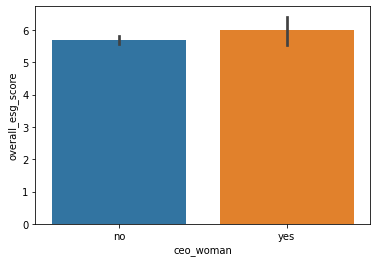

In [48]:
# sns.barplot(data=df, x="ceo_woman", y="overall_esg_score");

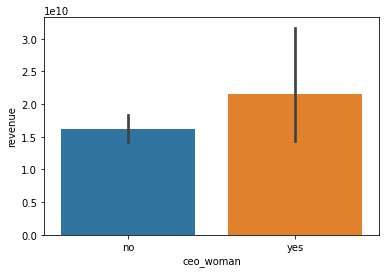

In [49]:
# sns.barplot(data=df, x="ceo_woman", y="revenue");

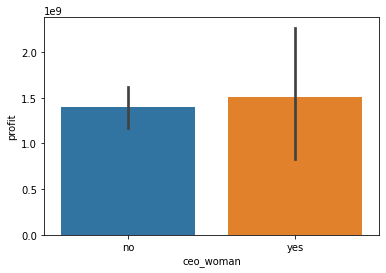

In [50]:
# sns.barplot(data=df, x="ceo_woman", y="profit");

[Text(0, 0, 'retailing'),
 Text(1, 0, 'energy'),
 Text(2, 0, 'technology'),
 Text(3, 0, 'health_care'),
 Text(4, 0, 'telecommunications'),
 Text(5, 0, 'motor_vehicles_parts'),
 Text(6, 0, 'financials'),
 Text(7, 0, 'food_drug_stores'),
 Text(8, 0, 'industrials'),
 Text(9, 0, 'aerospace_defense'),
 Text(10, 0, 'transportation'),
 Text(11, 0, 'media'),
 Text(12, 0, 'household_products'),
 Text(13, 0, 'food_beverages_tobacco'),
 Text(14, 0, 'wholesalers'),
 Text(15, 0, 'chemicals'),
 Text(16, 0, 'apparel'),
 Text(17, 0, 'hotels_restaurants_leisure'),
 Text(18, 0, 'business_services'),
 Text(19, 0, 'materials'),
 Text(20, 0, 'engineering_construction')]

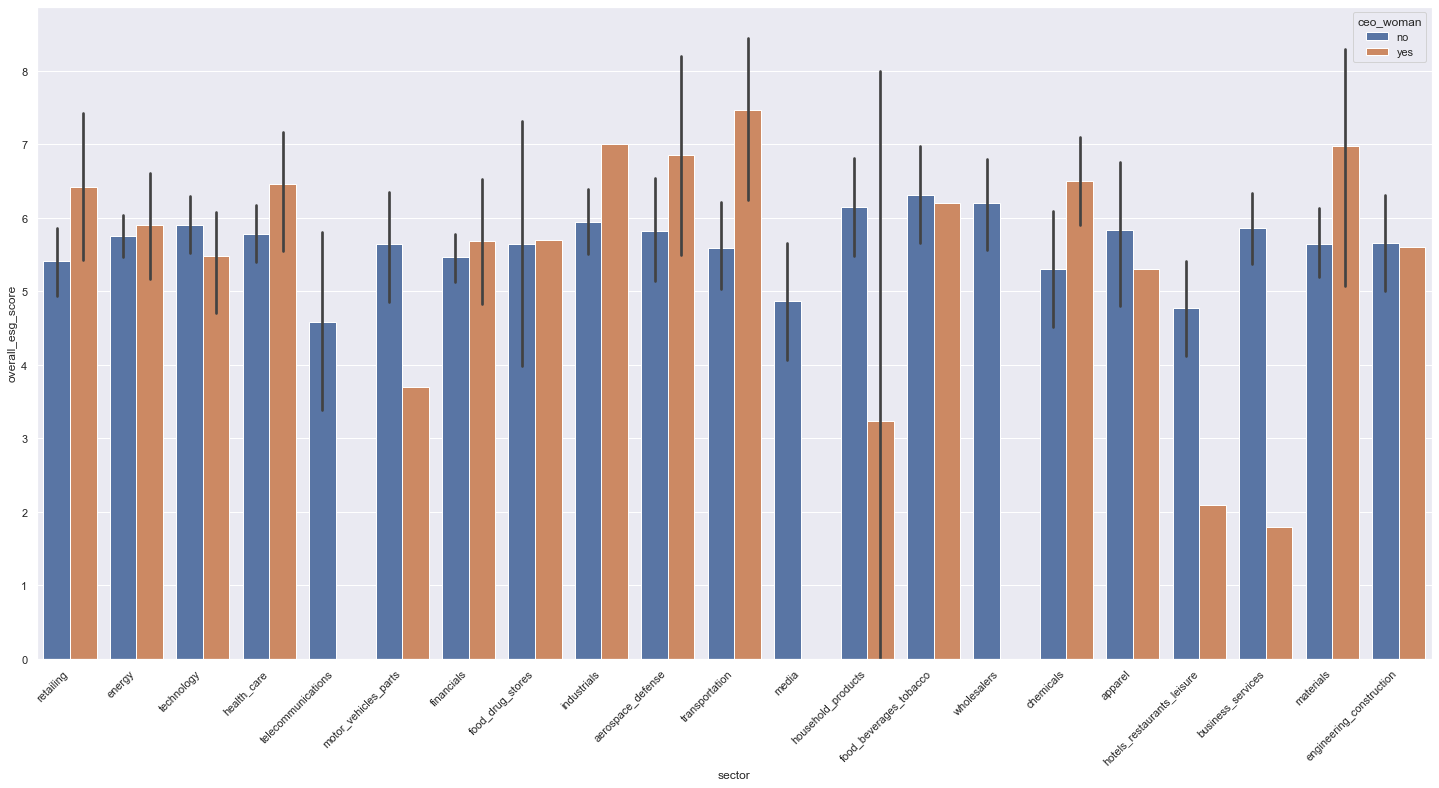

In [51]:
# sns.set(rc={'figure.figsize':(25,12)})

# ax = sns.barplot(x="sector", y="overall_esg_score", hue="ceo_woman", data=df)

# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha='right')

[Text(0, 0, 'retailing'),
 Text(1, 0, 'energy'),
 Text(2, 0, 'technology'),
 Text(3, 0, 'health_care'),
 Text(4, 0, 'telecommunications'),
 Text(5, 0, 'motor_vehicles_parts'),
 Text(6, 0, 'financials'),
 Text(7, 0, 'food_drug_stores'),
 Text(8, 0, 'industrials'),
 Text(9, 0, 'aerospace_defense'),
 Text(10, 0, 'transportation'),
 Text(11, 0, 'media'),
 Text(12, 0, 'household_products'),
 Text(13, 0, 'food_beverages_tobacco'),
 Text(14, 0, 'wholesalers'),
 Text(15, 0, 'chemicals'),
 Text(16, 0, 'apparel'),
 Text(17, 0, 'hotels_restaurants_leisure'),
 Text(18, 0, 'business_services'),
 Text(19, 0, 'materials'),
 Text(20, 0, 'engineering_construction')]

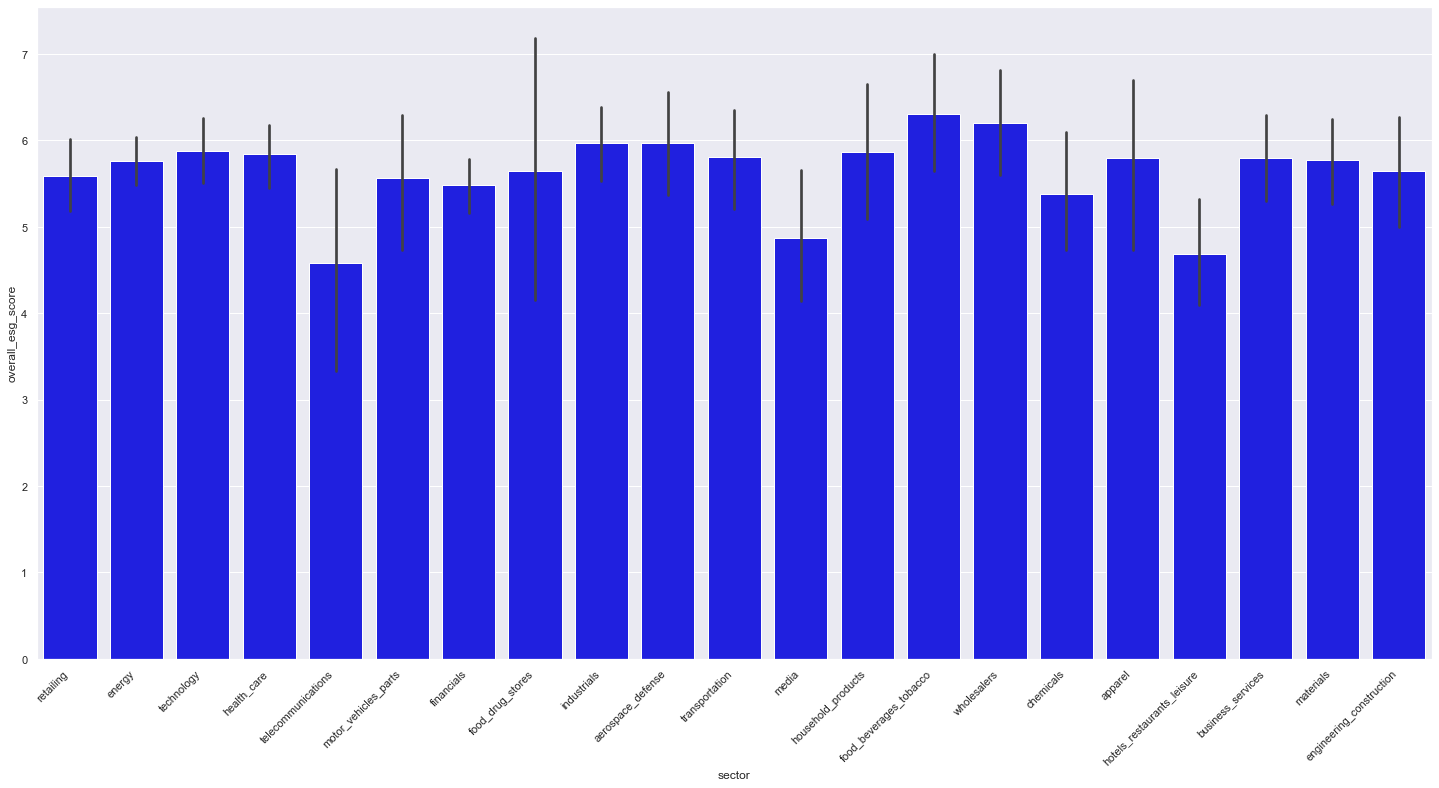

In [52]:
# sns.set(rc={'figure.figsize':(25,12)})

# ax = sns.barplot(x="sector", y="overall_esg_score", color="blue", data=df)

# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha='right')

[Text(0, 0, 'retailing'),
 Text(1, 0, 'energy'),
 Text(2, 0, 'technology'),
 Text(3, 0, 'health_care'),
 Text(4, 0, 'telecommunications'),
 Text(5, 0, 'motor_vehicles_parts'),
 Text(6, 0, 'financials'),
 Text(7, 0, 'food_drug_stores'),
 Text(8, 0, 'industrials'),
 Text(9, 0, 'aerospace_defense'),
 Text(10, 0, 'transportation'),
 Text(11, 0, 'media'),
 Text(12, 0, 'household_products'),
 Text(13, 0, 'food_beverages_tobacco'),
 Text(14, 0, 'wholesalers'),
 Text(15, 0, 'chemicals'),
 Text(16, 0, 'apparel'),
 Text(17, 0, 'hotels_restaurants_leisure'),
 Text(18, 0, 'business_services'),
 Text(19, 0, 'materials'),
 Text(20, 0, 'engineering_construction')]

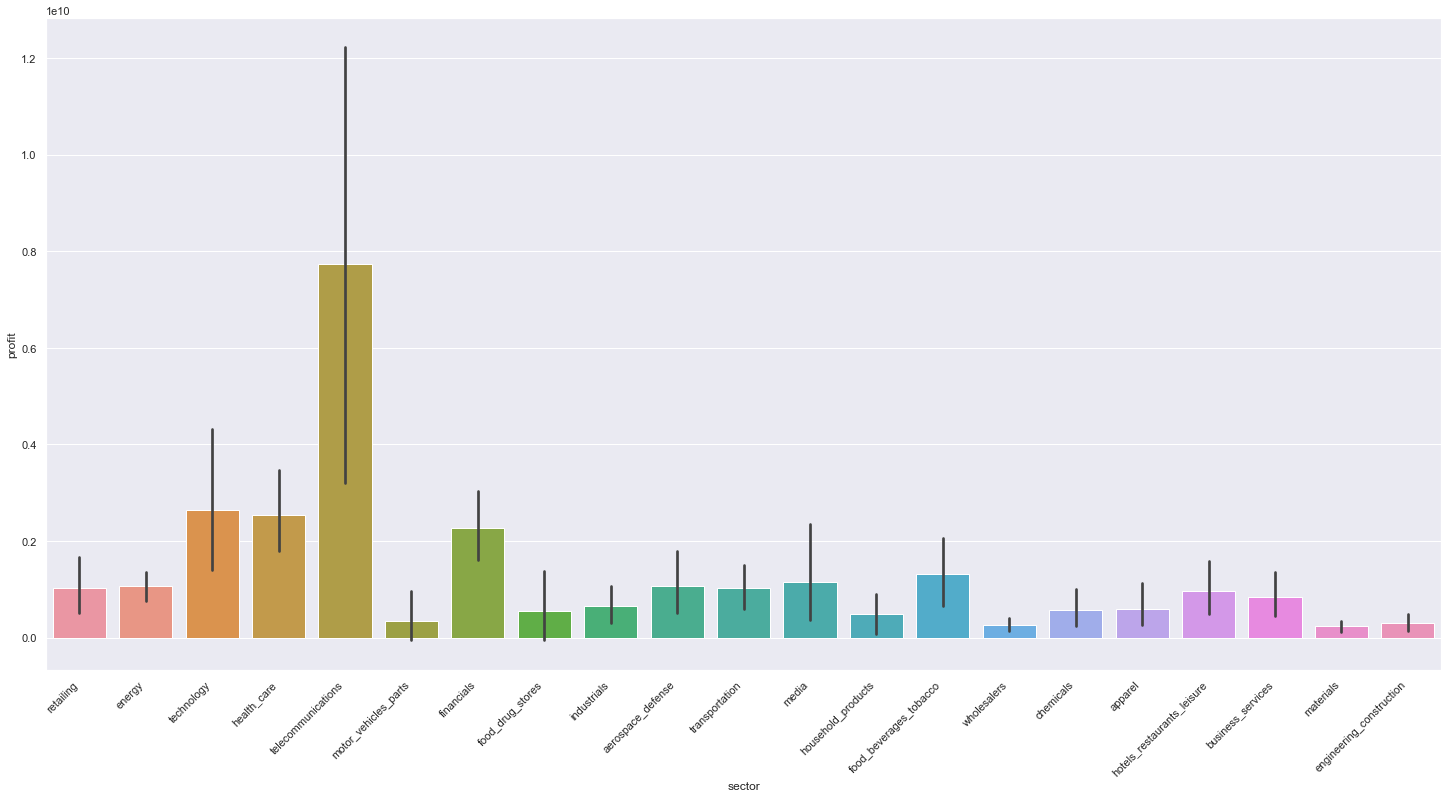

In [53]:
# sns.set(rc={'figure.figsize':(25,12)})

# ax = sns.barplot(x="sector", y="profit", data=df)

# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha='right')

In [54]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   float64
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

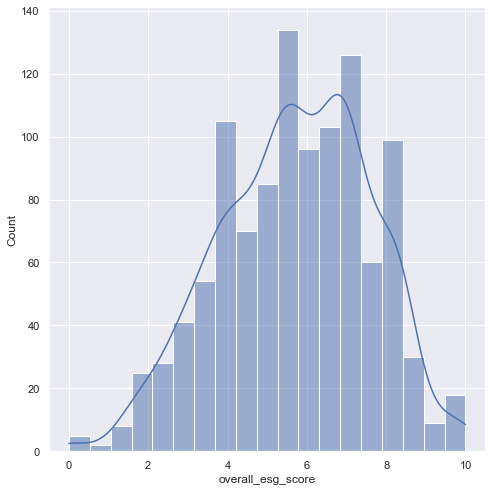

In [55]:
sns.set_theme(style="darkgrid")

sns.displot(
    df, x="overall_esg_score", height=7, facet_kws=dict(margin_titles=True), kde=True
);

In [56]:
sector_list = list(set(df.sector))

In [57]:
sector_list

['retailing',
 'hotels_restaurants_leisure',
 'materials',
 'food_drug_stores',
 'telecommunications',
 'chemicals',
 'technology',
 'health_care',
 'household_products',
 'engineering_construction',
 'financials',
 'business_services',
 'wholesalers',
 'apparel',
 'media',
 'energy',
 'industrials',
 'motor_vehicles_parts',
 'aerospace_defense',
 'transportation',
 'food_beverages_tobacco']

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


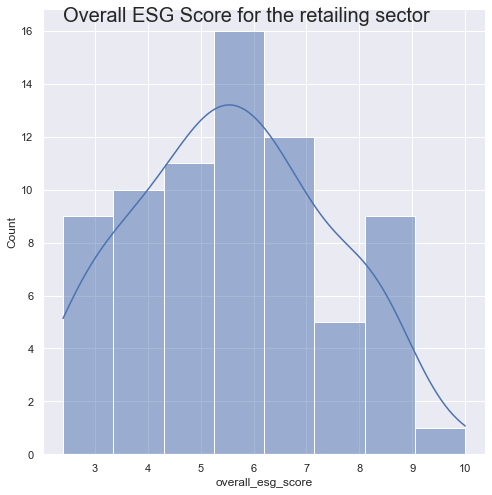

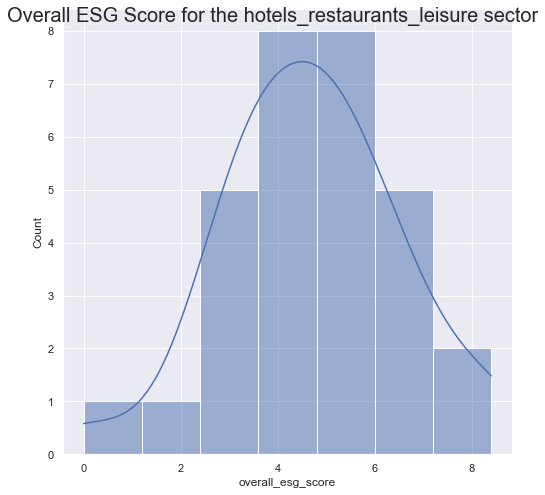

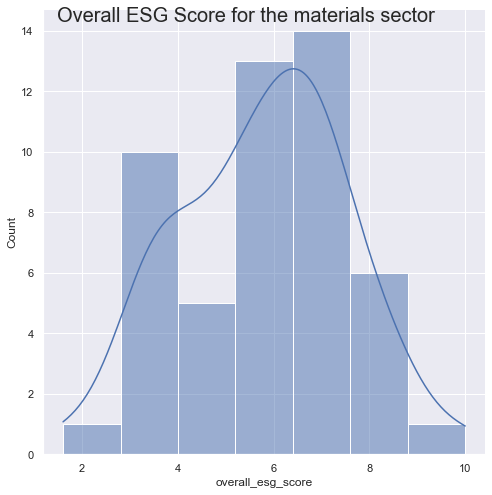

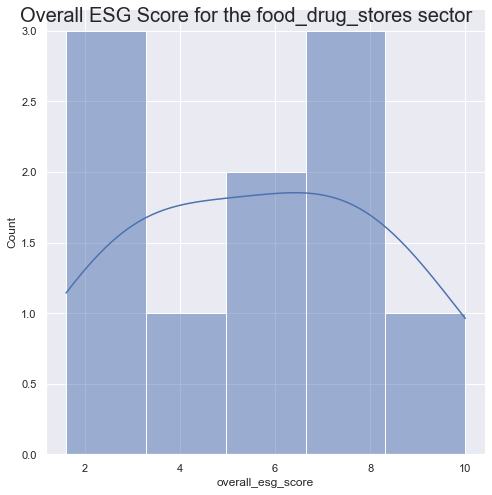

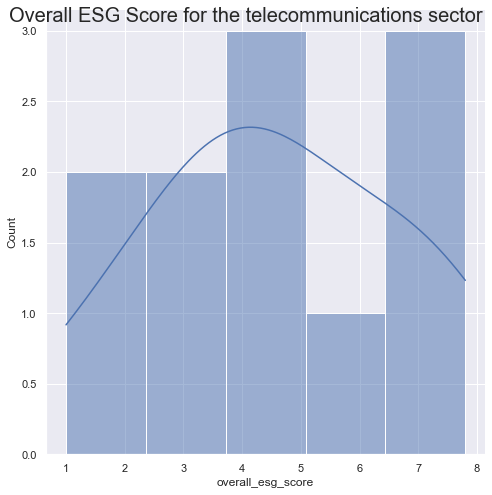

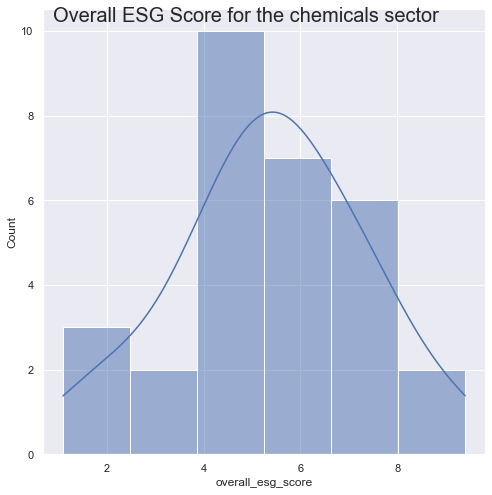

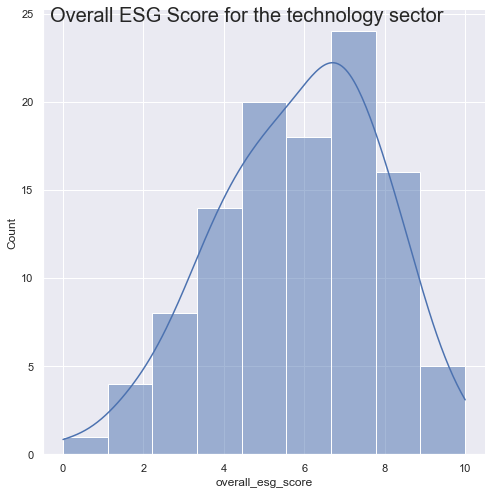

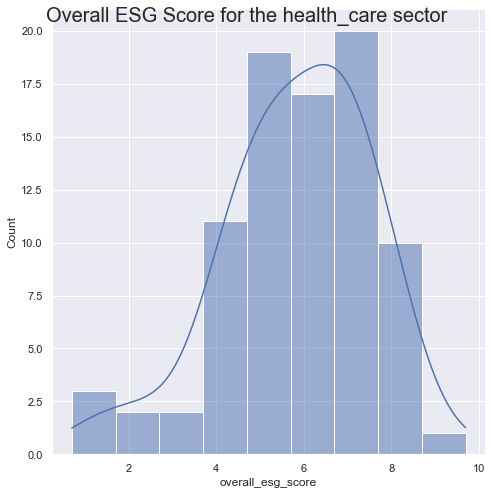

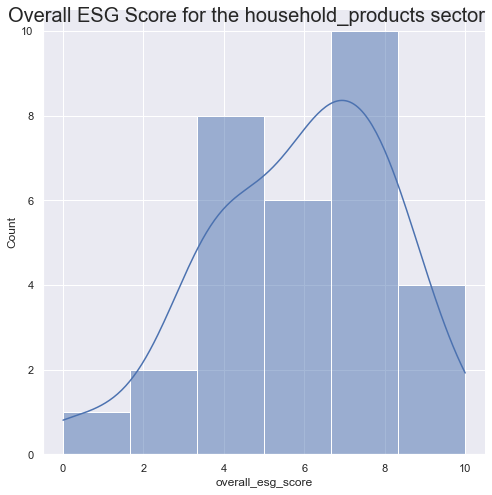

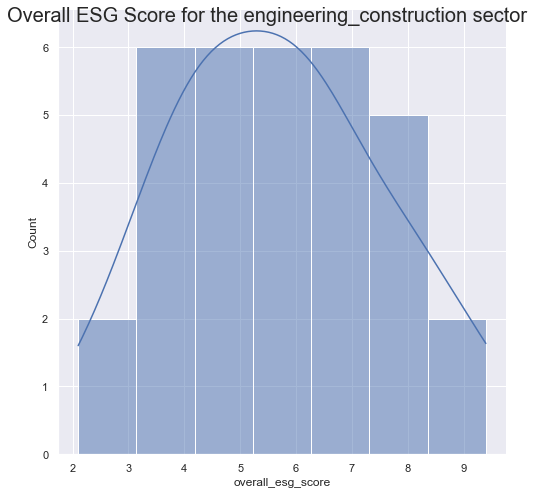

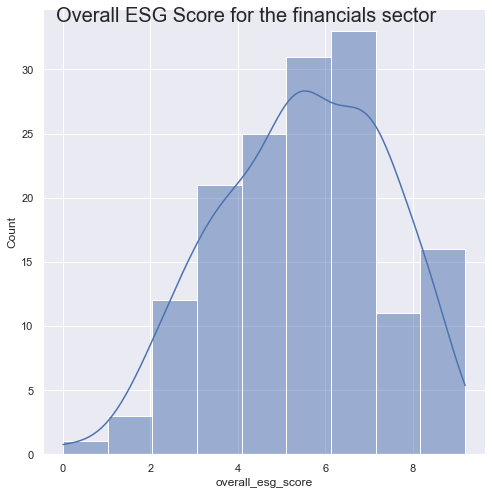

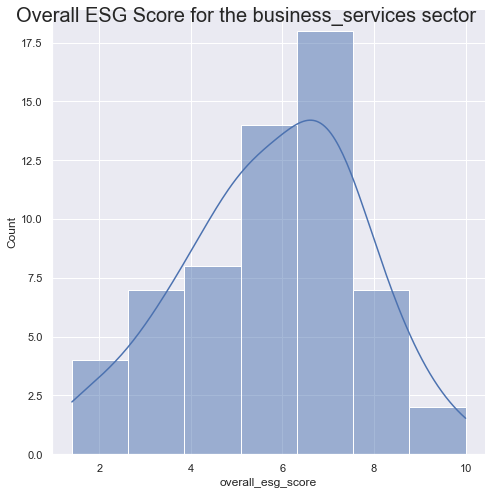

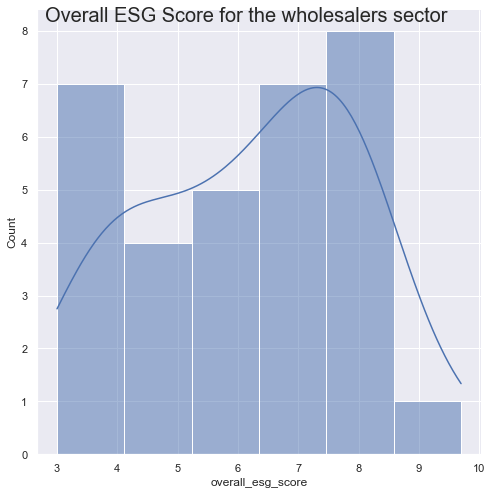

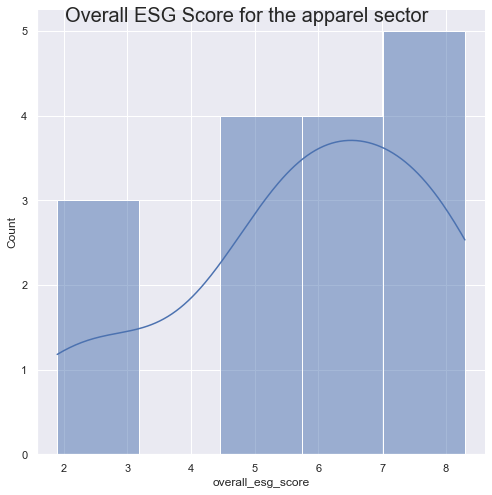

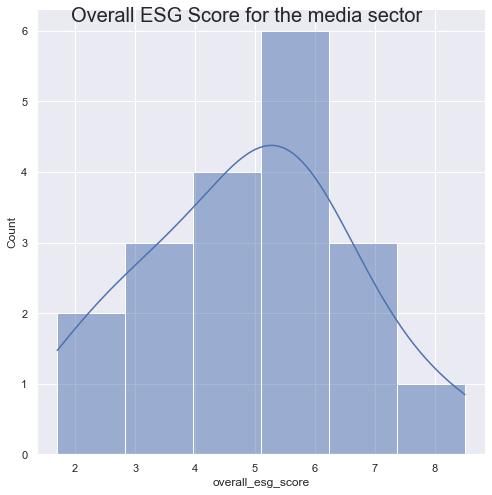

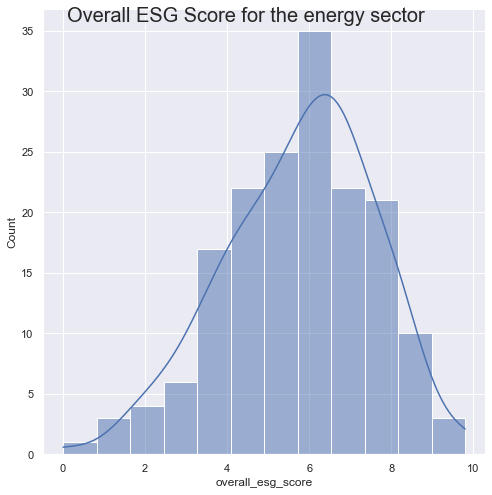

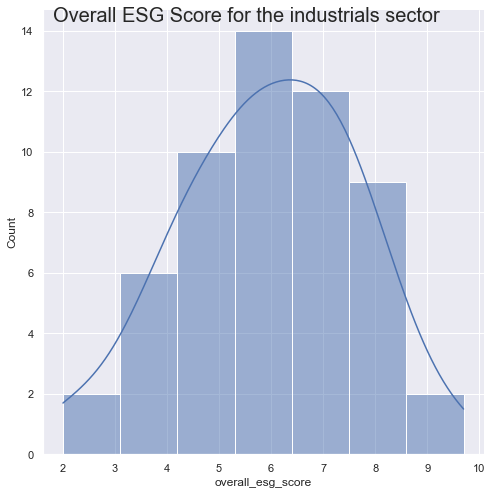

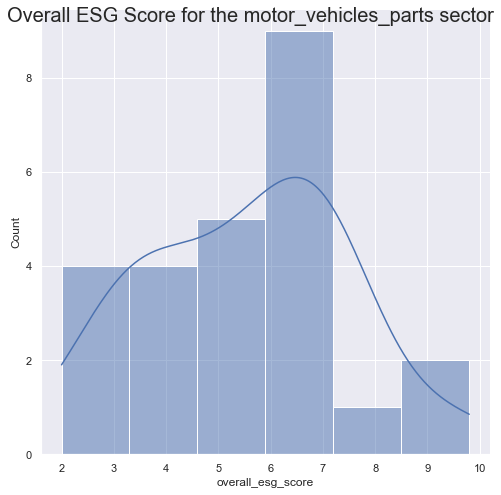

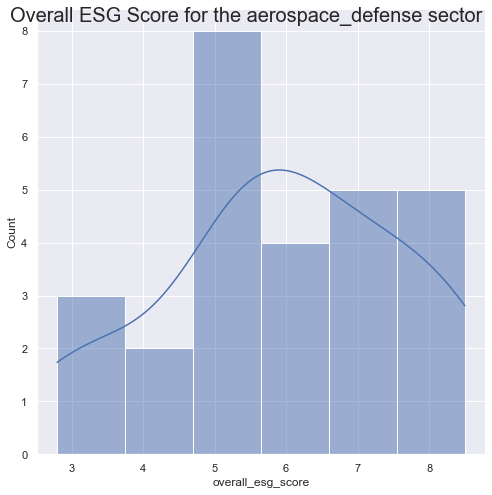

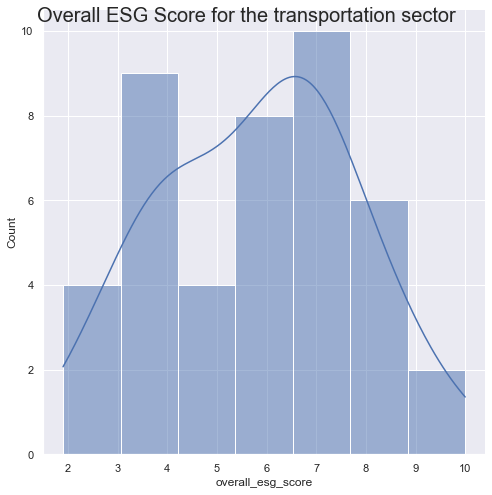

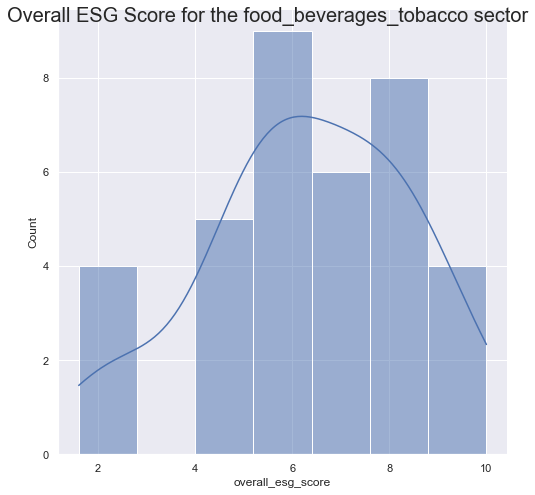

In [59]:
# for ind in sector_list:
#     sect = ind
#     sns.set_theme(style="darkgrid")
#     ax = sns.displot(
#         df.loc[df['sector'] == ind], x="overall_esg_score", height=7, facet_kws=dict(margin_titles=True), kde=True
#     )
#     ax.fig.suptitle('Overall ESG Score for the {} sector'.format(sect), fontsize=20);

### Begin Eval of features

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   float64
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

In [61]:
# I'll need to decide whether to include the ESG ranking scores, or if that will be too much of a giveaway
numeric_columns = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score', "rank", "revenue", "profit", "num_of_employees", 'market_cap']

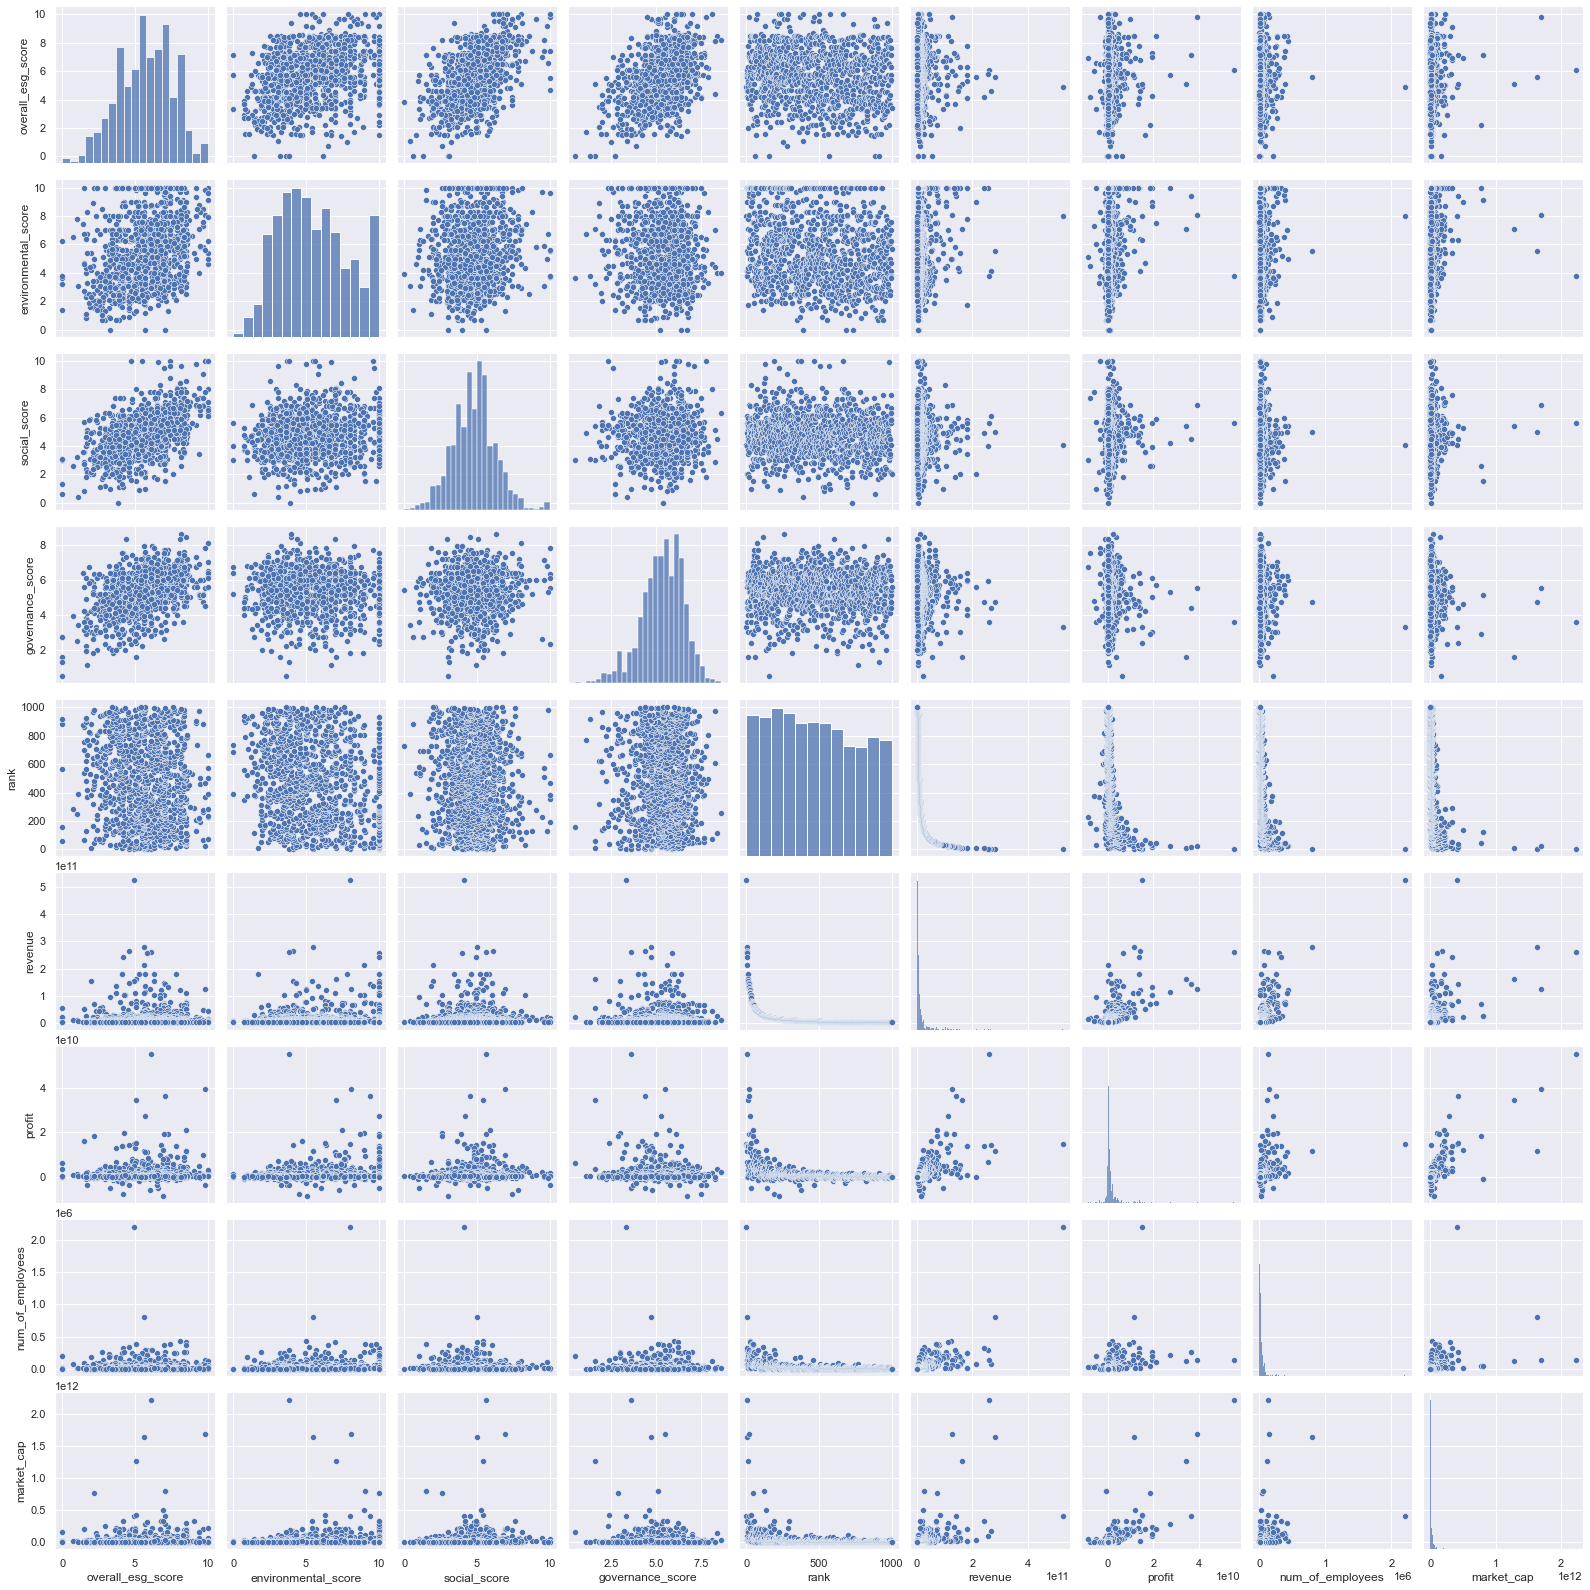

In [62]:
# sns.pairplot(df[numeric_columns]);

In [63]:
corr_num = df[numeric_columns].copy()

In [64]:
corr_num = corr_num.corr()

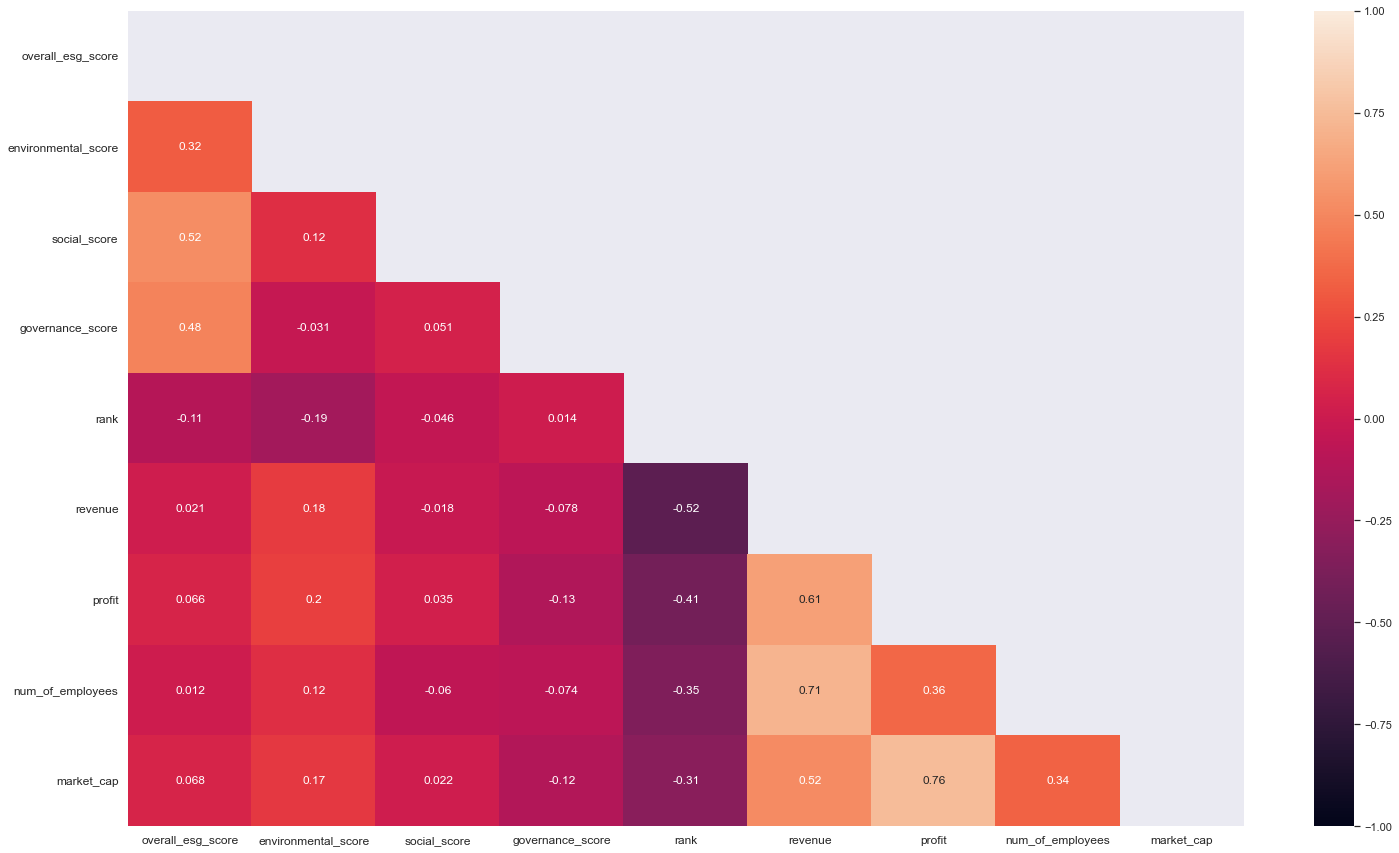

In [65]:
corr = round(corr_num,3)
sns.set(rc = {'figure.figsize':(25,15)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

Hmmm, not looking good - the numeric columns don't seem to have a strong correlation to the overall ESG score. Even the env, social, and governance score columns don't seem to have a large correlation to overall score, likely due to MSCI's weighting for different sectors.

# Initial Data and Feature Engineering

Look at financials on a per-employee basis (indicator of productivity)

In [66]:
df['profit_per_capita'] = df['profit'] / df['num_of_employees']
df['rev_per_capita'] = df['revenue'] / df['num_of_employees']
df['marcap_per_capita'] = df['market_cap'] / df['num_of_employees']

In [67]:
df.head()

company  rank       revenue        profit  num_of_employees  \
0      walmart     1  5.239640e+11  1.488100e+10           2200000   
1       amazon     2  2.805220e+11  1.158800e+10            798000   
3  exxon_mobil     3  2.649380e+11  1.434000e+10             74900   
5        apple     4  2.601740e+11  5.525600e+10            137000   
6   cvs_health     5  2.567760e+11  6.634000e+09            290000   

        sector                                subsector state newcomer  \
0    retailing               hypermarkets_super_centers    ar       no   
1    retailing         internet_direct_marketing_retail    wa       no   
3       energy                       integrated_oil_gas    tx       no   
5   technology  technology_hardware_storage_peripherals    ca       no   
6  health_care                     health_care_services    ri       no   

  ceo_founder  ... profitable    market_cap  overall_esg_rating  \
0          no  ...        yes  4.116900e+11                 bbb   
1         yes  ...        yes  1.637405e+12                 bbb   
3          no  ...        yes  1.779230e+11                 bbb   
5          no  ...        yes  2.221176e+12                   a   
6          no  ...        yes  9.849600e+10                   a   

  overall_esg_score  environmental_score  social_score  governance_score  \
0               4.9                  8.0           4.1               3.3   
1               5.6                  5.5           5.0               4.7   
3               4.6                  4.1           6.1               4.4   
5               6.1                  3.8           5.6               3.6   
6               5.8                 10.0           4.0               5.9   

   profit_per_capita  rev_per_capita  marcap_per_capita  
0        6764.090909    2.381655e+05       1.871318e+05  
1       14521.303258    3.515313e+05       2.051886e+06  
3      191455.273698    3.537223e+06       2.375474e+06  
5      403328.467153    1.899080e+06       1.621296e+07  
6       22875.862069    8.854345e+05       3.396414e+05  

[5 rows x 21 columns]

In [68]:
numeric_columns_2 = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita']

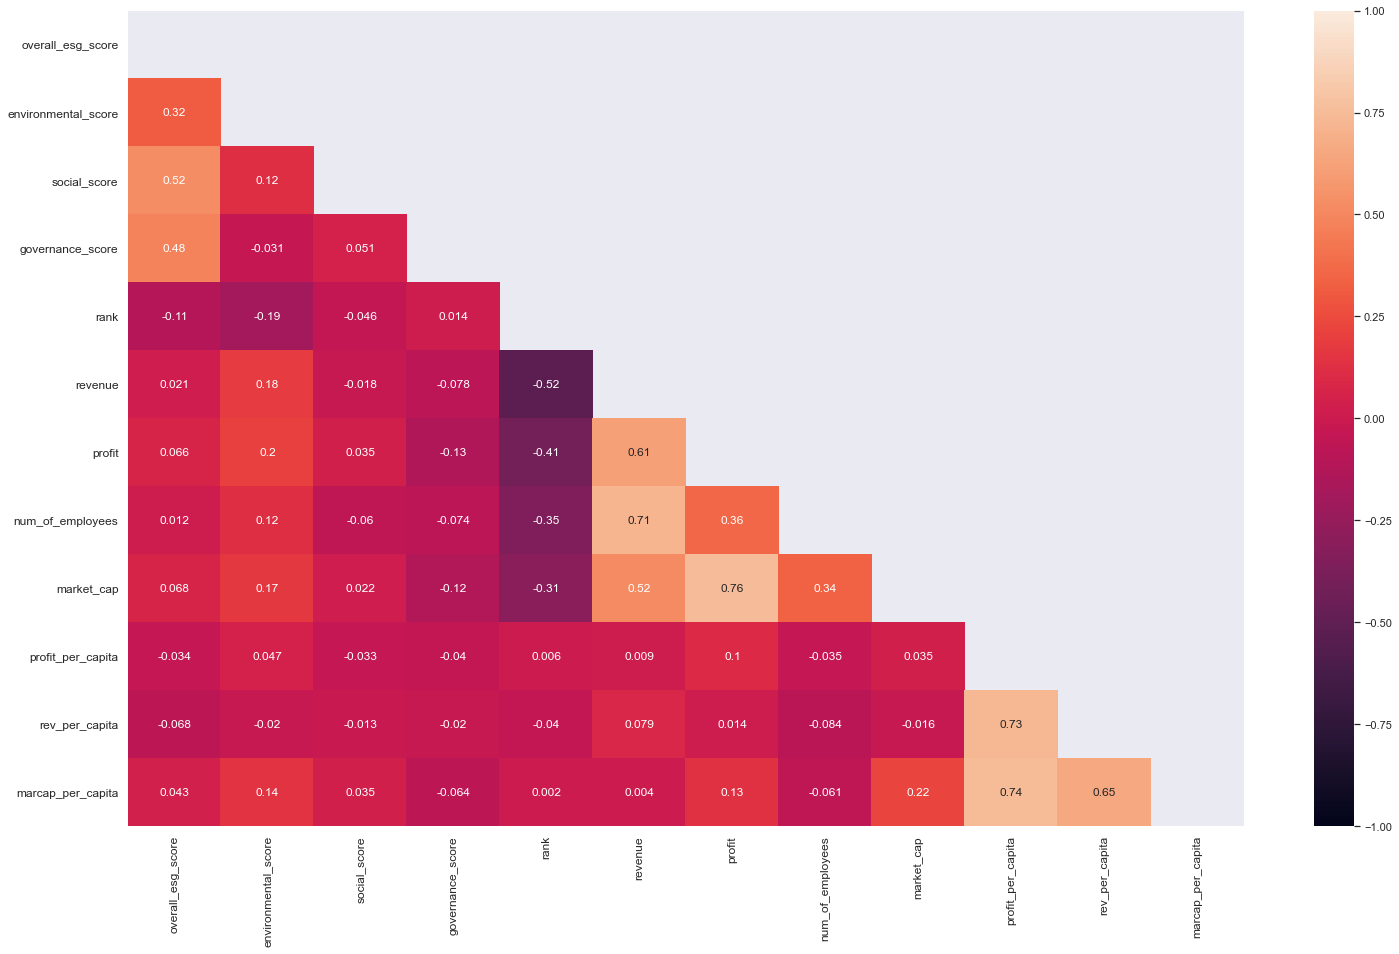

In [69]:
corr_num = df[numeric_columns_2].copy()

corr_num = corr_num.corr()

corr = round(corr_num,3)
sns.set(rc = {'figure.figsize':(25,15)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

In [70]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita'],
      dtype='object')

Now let's try weighting financials by their E, S and G scores

In [71]:
df['profit_env'] = df['profit'] * (df['environmental_score'] / 10)
df['profit_soc'] = df['profit'] * (df['social_score'] / 10)
df['profit_gov'] = df['profit'] * (df['governance_score'] / 10)
df['revenue_env'] = df['revenue'] * (df['environmental_score'] / 10)
df['revenue_soc'] = df['revenue'] * (df['social_score'] / 10)
df['revenue_gov'] = df['revenue'] * (df['governance_score'] / 10)
df['marcap_env'] = df['market_cap'] * (df['environmental_score'] / 10)
df['marcap_soc'] = df['market_cap'] * (df['social_score'] / 10)
df['marcap_gov'] = df['market_cap'] * (df['governance_score'] / 10)

In [72]:
numeric_columns_3 = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc', 'profit_gov',
                     'revenue_env', 'revenue_soc','revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

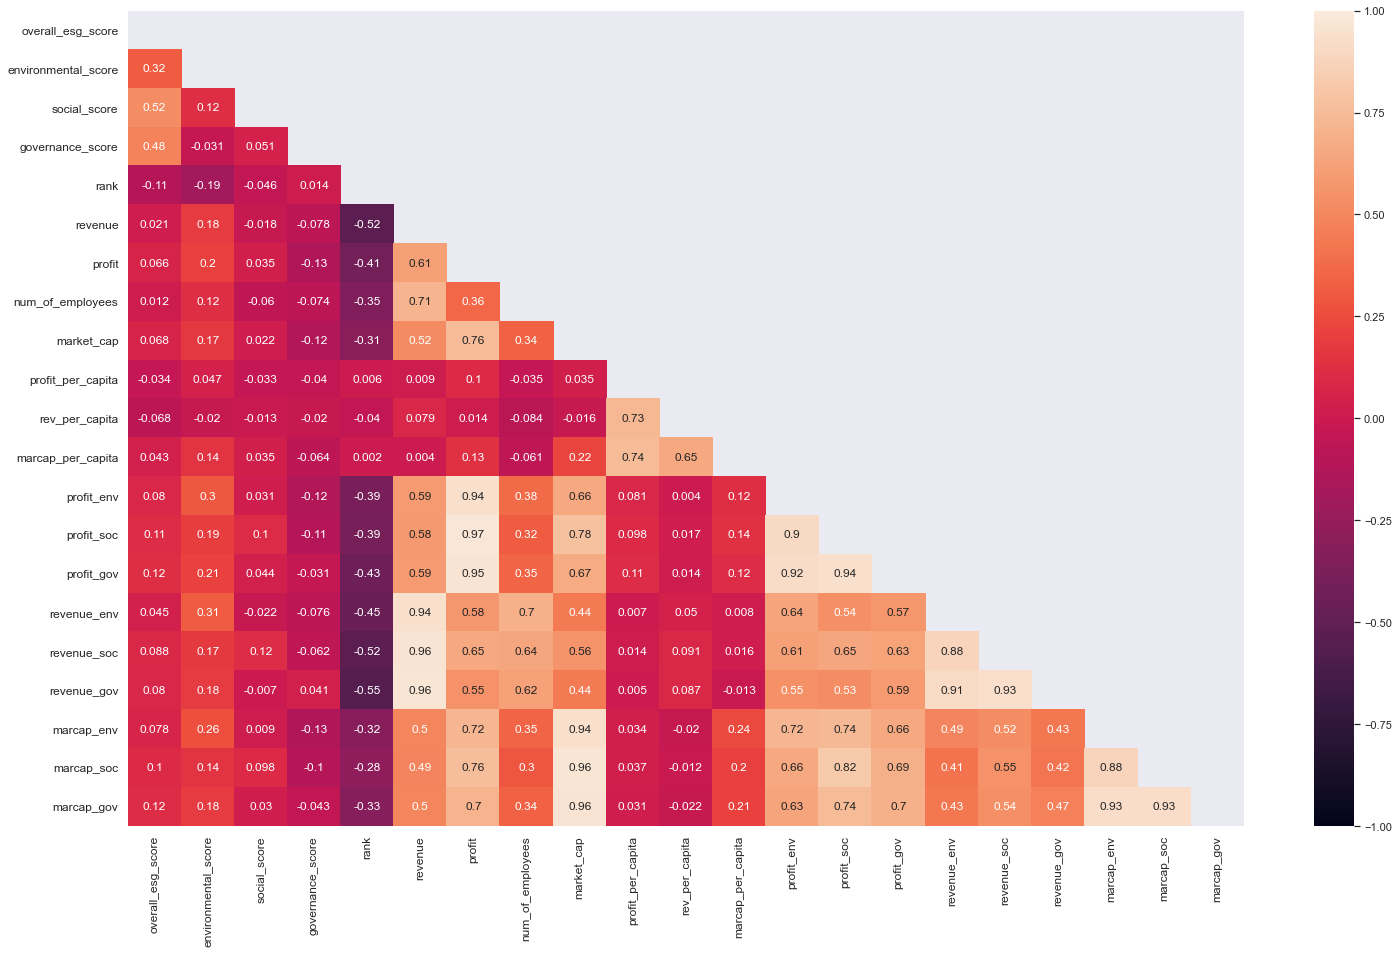

In [73]:
corr_num = df[numeric_columns_3].copy()

corr_num = corr_num.corr()

corr = round(corr_num,3)
sns.set(rc = {'figure.figsize':(25,15)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

Damn, none of these have a strong relationship either...

# Add Additional Target Variable - reduced to 3 classes

In MSCI's Framework, companies can be broken down into 3 groups based on their ESG Rating:


-Laggard
 - A company lagging its industry based on its high exposure and failure to manage significant ESG risks
 
 
-Average
 - A company with a mixed or unexceptional track record of managing the most significant ESG risks and opportunities relative to industry peers
 
 
-Leader
 - A company leading its industry in managing the most significant ESG risks and opportunities

In [74]:
def classify(value):
    if value >= 2.857 and value < 7.143:
        return "Average"
    elif value >= 7.143:
        return "Leader"
    else:
        return "Laggard"

In [75]:
df['classification'] = df.apply(lambda row: classify(row['overall_esg_score']), axis = 1)

In [76]:
df.classification.value_counts()

Average    778
Leader     240
Laggard     80
Name: classification, dtype: int64

# Initial Modeling

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   float64
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

In [78]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov',
       'classification'],
      dtype='object')

In [79]:
relevant_columns_all = ['environmental_score', 'social_score', 'governance_score',
  'revenue', 'profit', 'num_of_employees', 'market_cap', 'profit_per_capita',
  'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc',
  'profit_gov', 'revenue_env', 'revenue_soc', 'revenue_gov', 'marcap_env',
  'marcap_soc', 'marcap_gov', 'sector', 'subsector', 'state', 'ceo_founder',
  'ceo_woman', 'profitable']

In [80]:
len(relevant_columns_all)

25

In [81]:
relevant_columns_no_esg = ['revenue', 'profit', 'num_of_employees', 'sector',
                      'ceo_founder', 'ceo_woman', 'profitable','market_cap',
                      'profit_per_capita', 'rev_per_capita', 'marcap_per_capita']

In [82]:
relevant_columns_esg_finance = ['revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'ceo_founder', 'ceo_woman', 'profitable',
       'market_cap', 'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

In [83]:
relevant_columns_esg_explicit = ['revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'ceo_founder', 'ceo_woman', 'profitable',
       'market_cap', 'environmental_score', 'social_score', 'governance_score',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

Evaluate target variables

In [84]:
df.overall_esg_rating.value_counts()

a      301
bbb    287
aa     208
bb     190
b       71
aaa     32
ccc      9
Name: overall_esg_rating, dtype: int64

In [85]:
X = df[relevant_columns_all]
y = df['overall_esg_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [86]:
#Verify no nulls
X_train.isna().sum()

environmental_score    0
social_score           0
governance_score       0
revenue                0
profit                 0
num_of_employees       0
market_cap             0
profit_per_capita      0
rev_per_capita         0
marcap_per_capita      0
profit_env             0
profit_soc             0
profit_gov             0
revenue_env            0
revenue_soc            0
revenue_gov            0
marcap_env             0
marcap_soc             0
marcap_gov             0
sector                 0
subsector              6
state                  0
ceo_founder            0
ceo_woman              0
profitable             0
dtype: int64

In [87]:
# Use these mini-pipelines to solve for our our ColumnTransformer: numeric and categorical
subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(missing_values=None, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [88]:
numeric_columns_all = ['environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc', 'profit_gov',
                     'revenue_env', 'revenue_soc','revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

In [89]:
cat_columns_all = ['sector', 'subsector', 'state', 'ceo_founder', 'ceo_woman',
                   'profitable']

In [90]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

### Dummy Model Pipe

In [91]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy="stratified"))
])


In [92]:
dummy_model = dummy_model_pipe.fit(X_train, y_train)

In [93]:
dummy_model.score(X_train, y_train)

0.2235722964763062

In [94]:
dummy_model.score(X_test, y_test)

0.23272727272727273

Hmmm, it works on the overall training and test set, but not yet on the SMOTE Resample set (below)

Below Class taken from lesson 51-workflow_with_pipelines.ipynb

In [95]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [96]:
def scoring(model_pipe, X_train, X_test, y_train, y_test):
    model = model_pipe.fit(X_train, y_train)
    
    # Test Predisctions
    preds = model.predict(X_test)
    
    #Metrics for testing
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted')
    rec = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    
    # Training Results
    model_cv = ModelWithCV(model_pipe, 'train_model', X_train, y_train)
    print(f'Test Data Results:\n',
            f'accuracy - {acc} \n',
            f'precision - {prec} \n',
            f'recall - {rec} \n',
            f'F1 Score - {f1} \n')
    model_cv.print_cv_summary()

In [97]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dummy_model` Model'}>

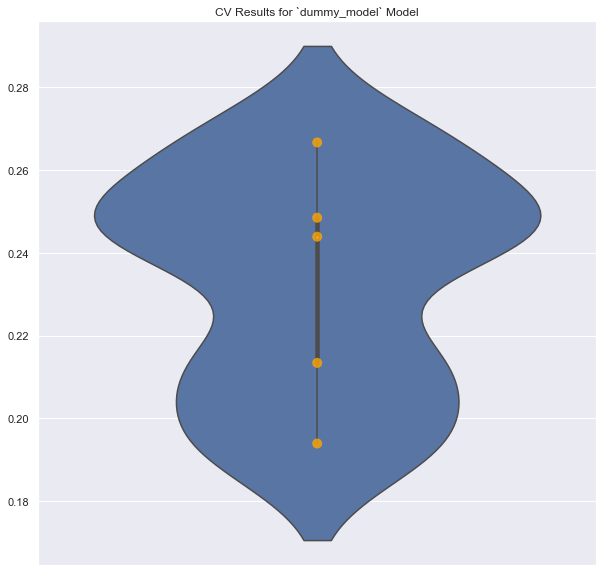

In [98]:
# Use the class with out dummy pipe

fig, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax)

In [99]:
dummy_pipe.print_cv_summary()

CV Results for `dummy_model` model:
            0.23328 ± 0.02608 accuracy
        


In [100]:
dummy_pipe.cv_mean

0.23328159645232813

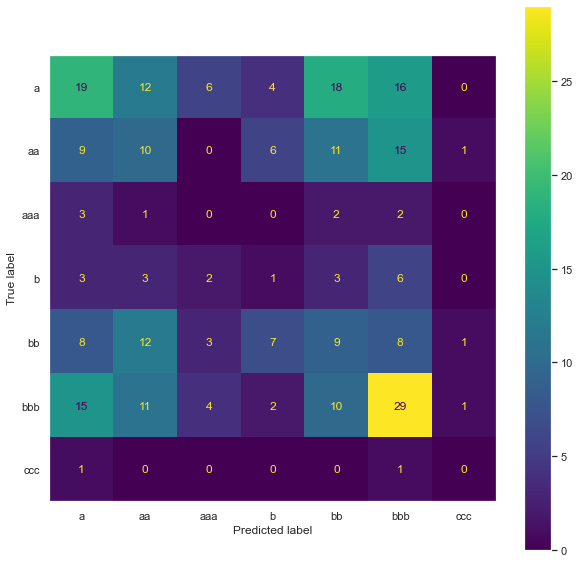

In [101]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax)

ax.grid(False);

In [102]:
scoring(dummy_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.14545454545454545 
 precision - 0.1479420505836478 
 recall - 0.14545454545454545 
 F1 Score - 0.14607900973085816 

CV Results for `train_model` model:
            0.20415 ± 0.03746 accuracy
        


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Decision Tree

In [103]:
# dtc!


dtc_model_pipe = Pipeline([('ct',CT),('dtc', DecisionTreeClassifier(random_state=42))])

In [104]:
dtc_pipe = ModelWithCV(dtc_model_pipe, 'dtc_model', X_train, y_train)

dtc_pipe.print_cv_summary()

CV Results for `dtc_model` model:
            0.37555 ± 0.04773 accuracy
        


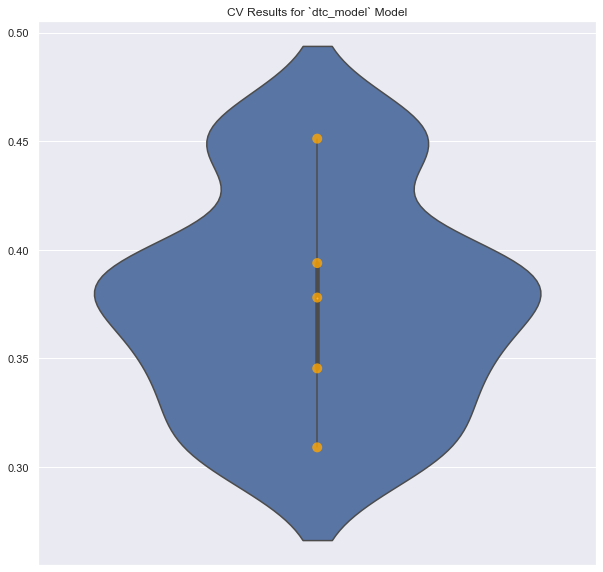

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

dtc_pipe.plot_cv(ax);

In [106]:
dtc_model = dtc_model_pipe.fit(X_train, y_train)

In [107]:
y_test.value_counts()

a      75
bbb    72
aa     52
bb     48
b      18
aaa     8
ccc     2
Name: overall_esg_rating, dtype: int64

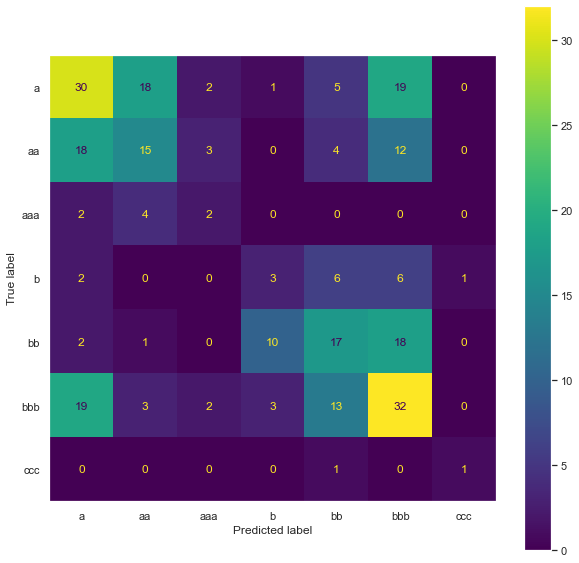

In [108]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(dtc_model, X_test, y_test, ax=ax)

ax.grid(False);

In [109]:
scoring(dtc_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.36363636363636365 
 precision - 0.3637179835403889 
 recall - 0.36363636363636365 
 F1 Score - 0.36178363775932554 

CV Results for `train_model` model:
            0.37555 ± 0.04773 accuracy
        


### KNN

In [110]:
# knn!


knn_model_pipe = Pipeline([('ct',CT),('knn',KNeighborsClassifier())])

In [111]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_model', X_train, y_train)

knn_pipe.print_cv_summary()

CV Results for `knn_model` model:
            0.32809 ± 0.02307 accuracy
        


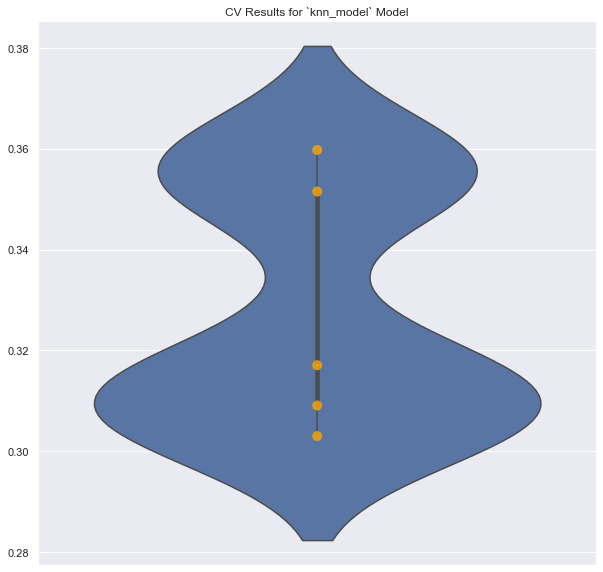

In [112]:
fig, ax = plt.subplots(figsize=(10,10))

knn_pipe.plot_cv(ax);

In [113]:
knn_model = knn_model_pipe.fit(X_train, y_train)

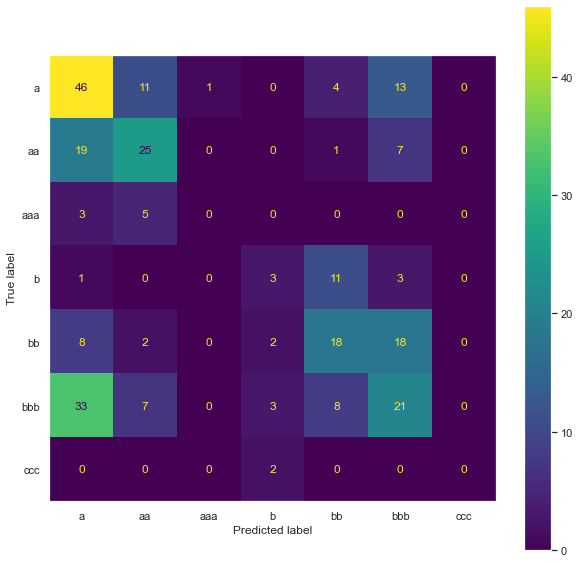

In [114]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(knn_model, X_test, y_test, ax=ax)
ax.grid(False);

In [115]:
scoring(knn_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4109090909090909 
 precision - 0.39171695167003084 
 recall - 0.4109090909090909 
 F1 Score - 0.3942247287708218 

CV Results for `train_model` model:
            0.32809 ± 0.02307 accuracy
        


### Random Forest

In [116]:
# rfc!


rfc_model_pipe = Pipeline([('ct',CT),('rfc',RandomForestClassifier(random_state=42))])

In [117]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_train, y_train)

rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.40225 ± 0.04089 accuracy
        


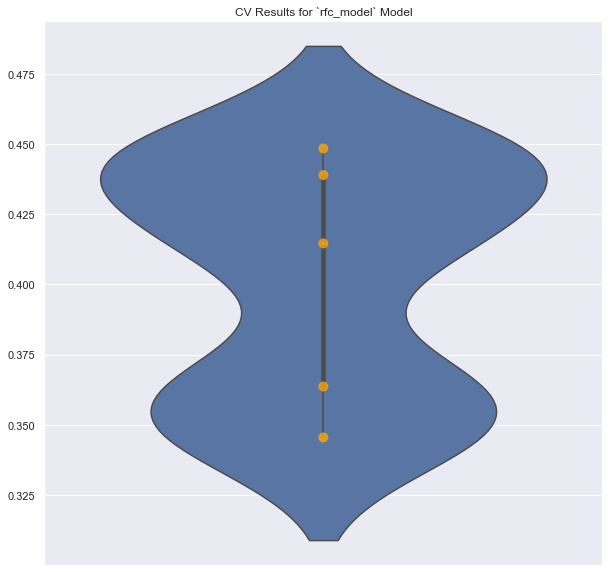

In [118]:
fig, ax = plt.subplots(figsize=(10,10))

rfc_pipe.plot_cv(ax);

In [119]:
rfc_model = rfc_model_pipe.fit(X_train, y_train)

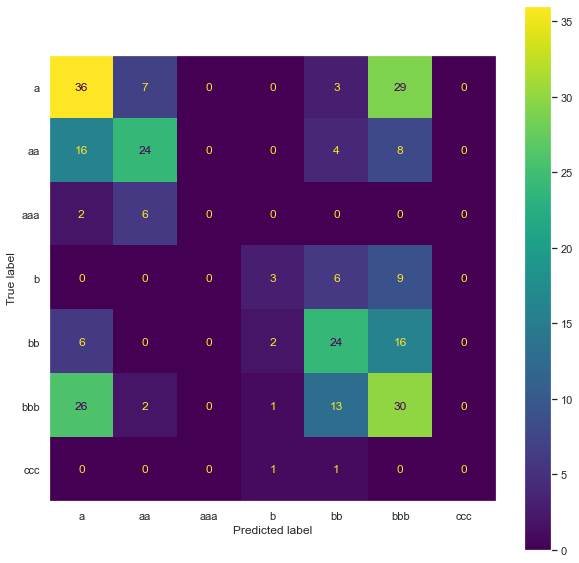

In [120]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(rfc_model, X_test, y_test, ax=ax)
ax.grid(False);

In [121]:
scoring(rfc_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4254545454545455 
 precision - 0.4260950207824651 
 recall - 0.4254545454545455 
 F1 Score - 0.417829581042692 

CV Results for `train_model` model:
            0.40225 ± 0.04089 accuracy
        


### Gradient Booster

In [122]:
# gbc!

gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbc',gbc)])

In [123]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)

gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.40224 ± 0.02774 accuracy
        


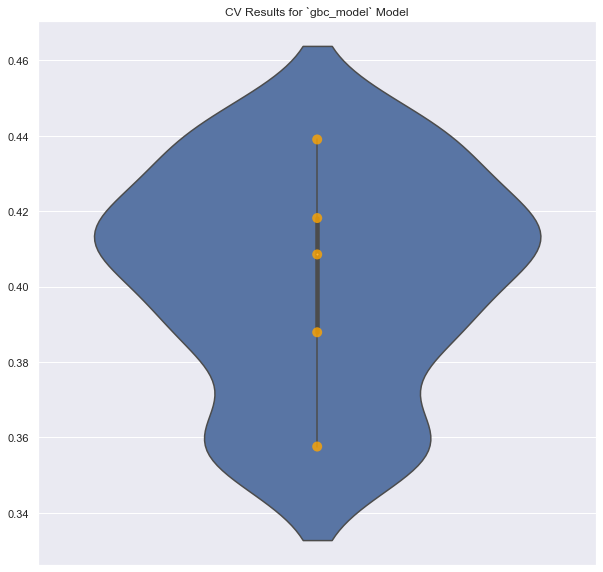

In [124]:
fig, ax = plt.subplots(figsize=(10,10))

gbc_pipe.plot_cv(ax);

In [125]:
gbc_model = gbc_model_pipe.fit(X_train, y_train)

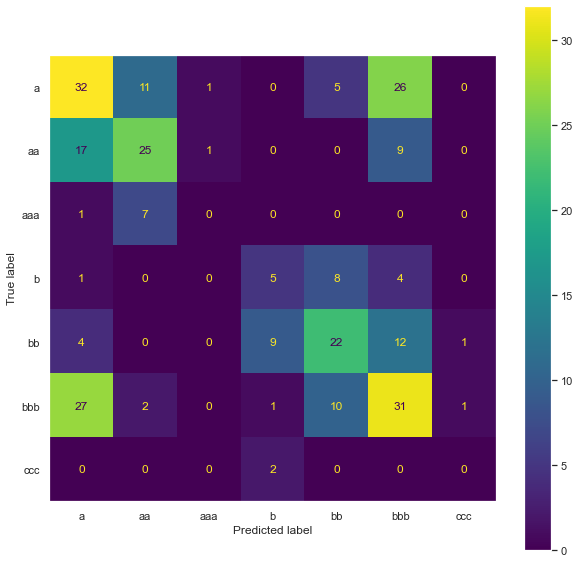

In [126]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(gbc_model, X_test, y_test, ax = ax)
ax.grid(False);

In [127]:
scoring(gbc_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.41818181818181815 
 precision - 0.4150453748387751 
 recall - 0.41818181818181815 
 F1 Score - 0.41533425333894 

CV Results for `train_model` model:
            0.40224 ± 0.02774 accuracy
        


### XGBoost

In [128]:
# gbc!

xgb = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6, disable_default_eval_metric=True, eval_metric='mlogloss', verbosity=0)

xgb_model_pipe = Pipeline([('ct', CT), ('xgb',xgb)])

In [129]:
xgb_pipe = ModelWithCV(xgb_model_pipe, 'gbc_model', X_train, y_train)

xgb_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.38157 ± 0.02973 accuracy
        


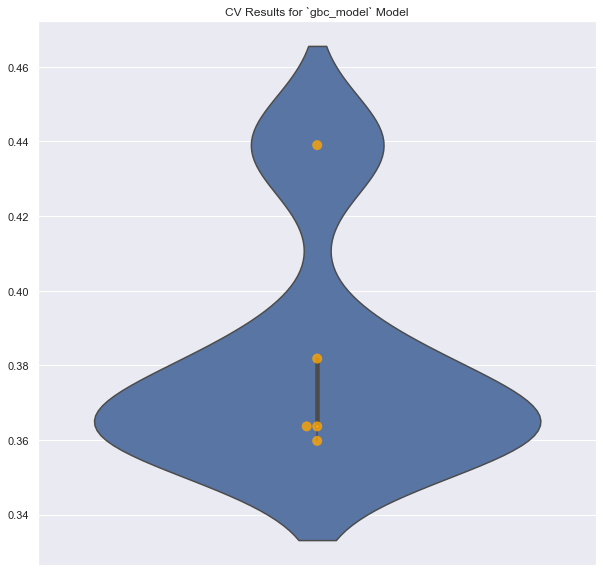

In [130]:
fig, ax = plt.subplots(figsize=(10,10))

xgb_pipe.plot_cv(ax);

In [131]:
xgb_model = xgb_model_pipe.fit(X_train, y_train)

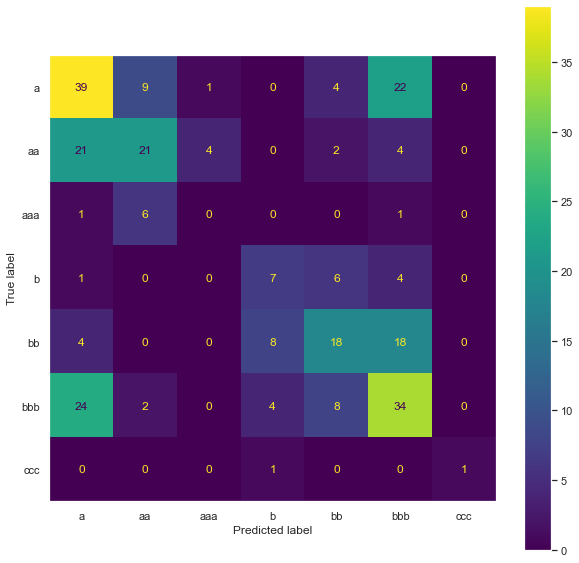

In [132]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(xgb_model, X_test, y_test, ax = ax)

ax.grid(False);

In [133]:
scoring(xgb_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.43636363636363634 
 precision - 0.44279149132414825 
 recall - 0.43636363636363634 
 F1 Score - 0.4340590706615324 

CV Results for `train_model` model:
            0.38157 ± 0.02973 accuracy
        


### ADABoost

In [134]:
# gbc!

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100, random_state=42)

ada_model_pipe = Pipeline([('ct', CT), ('ada',ada)])

In [135]:
ada_pipe = ModelWithCV(ada_model_pipe, 'ada_model', X_train, y_train)

ada_pipe.print_cv_summary()

CV Results for `ada_model` model:
            0.35601 ± 0.02725 accuracy
        


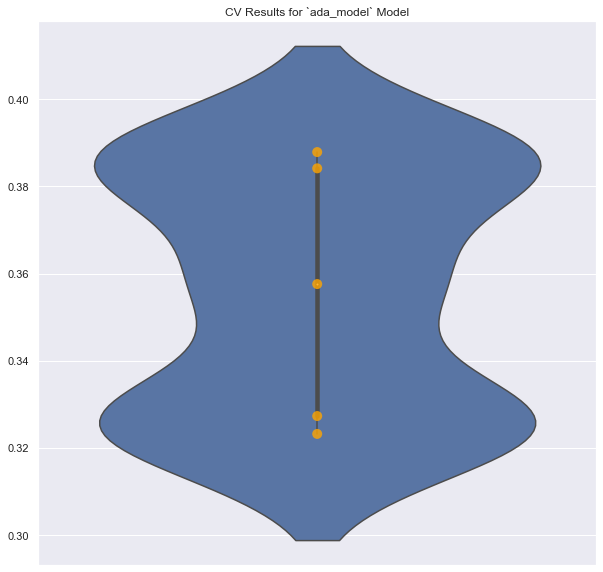

In [136]:
fig, ax = plt.subplots(figsize=(10,10))

ada_pipe.plot_cv(ax);

In [137]:
ada_model = ada_model_pipe.fit(X_train, y_train)

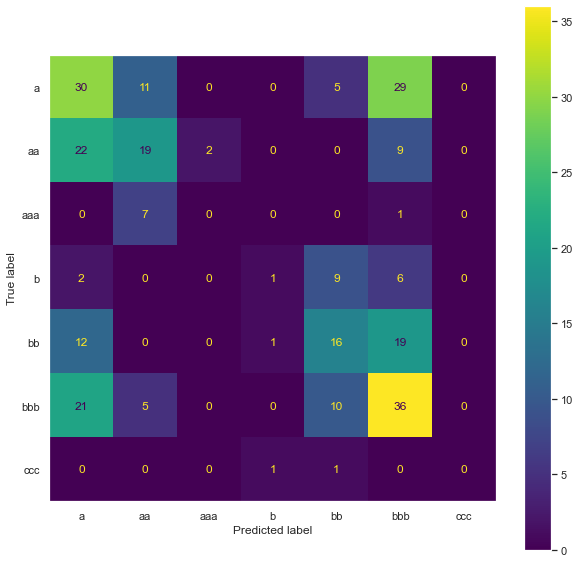

In [138]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(ada_model, X_test, y_test, ax = ax)
ax.grid(False);

In [139]:
scoring(ada_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.3709090909090909 
 precision - 0.3637730392959998 
 recall - 0.3709090909090909 
 F1 Score - 0.3560410979557136 

CV Results for `train_model` model:
            0.35601 ± 0.02725 accuracy
        


### Complement naive Bayes - doesn't work unless I transform into frequency counts for each of the features

In [140]:
# # gbc!

# cnb = ComplementNB()

# cnb_model_pipe = Pipeline([('ct', CT), ('cnb',cnb)])

In [141]:
# cnb_pipe = ModelWithCV(cnb_model_pipe, 'cnb_model', X_train, y_train)

# cnb_pipe.print_cv_summary()

In [142]:
# fig, ax = plt.subplots(figsize=(10,10))

# cnb_pipe.plot_cv(ax);

In [143]:
# cnb_model = cnb_model_pipe.fit(X_train, y_train)

In [144]:
# fig, ax = plt.subplots(figsize=(10,10))

# plot_confusion_matrix(cnb_model, X_test, y_test, ax = ax)

In [145]:
# scoring(cnb_model, X_train, X_test, y_train, y_test)

In [146]:
print('Dummy:\n',
      scoring(dummy_model, X_train, X_test, y_train, y_test),
     'Decision Tree:\n',
      scoring(dtc_model, X_train, X_test, y_train, y_test),
     'KNN:\n',
      scoring(knn_model, X_train, X_test, y_train, y_test),
     'RandomForest:\n',
      scoring(rfc_model, X_train, X_test, y_train, y_test),
     'Gradient Boosted:\n',
      scoring(gbc_model, X_train, X_test, y_train, y_test),
     'XGBoost:\n',
      scoring(xgb_model, X_train, X_test, y_train, y_test),
     'ADABoost:\n',
      scoring(ada_model, X_train, X_test, y_train, y_test))

Test Data Results:
 accuracy - 0.2727272727272727 
 precision - 0.2784506889964799 
 recall - 0.2727272727272727 
 F1 Score - 0.27505050505050505 

CV Results for `train_model` model:
            0.21753 ± 0.02009 accuracy
        
Test Data Results:
 accuracy - 0.36363636363636365 
 precision - 0.3637179835403889 
 recall - 0.36363636363636365 
 F1 Score - 0.36178363775932554 

CV Results for `train_model` model:
            0.37555 ± 0.04773 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4109090909090909 
 precision - 0.39171695167003084 
 recall - 0.4109090909090909 
 F1 Score - 0.3942247287708218 

CV Results for `train_model` model:
            0.32809 ± 0.02307 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4254545454545455 
 precision - 0.4260950207824651 
 recall - 0.4254545454545455 
 F1 Score - 0.417829581042692 

CV Results for `train_model` model:
            0.40225 ± 0.04089 accuracy
        
Test Data Results:
 accuracy - 0.41818181818181815 
 precision - 0.4150453748387751 
 recall - 0.41818181818181815 
 F1 Score - 0.41533425333894 

CV Results for `train_model` model:
            0.40224 ± 0.02774 accuracy
        
Test Data Results:
 accuracy - 0.43636363636363634 
 precision - 0.44279149132414825 
 recall - 0.43636363636363634 
 F1 Score - 0.4340590706615324 

CV Results for `train_model` model:
            0.38157 ± 0.02973 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.3709090909090909 
 precision - 0.3637730392959998 
 recall - 0.3709090909090909 
 F1 Score - 0.3560410979557136 

CV Results for `train_model` model:
            0.35601 ± 0.02725 accuracy
        
Dummy:
 None Decision Tree:
 None KNN:
 None RandomForest:
 None Gradient Boosted:
 None XGBoost:
 None ADABoost:
 None


# Grid Search/Parameter Tuning on XGBoost Model

In [147]:
# xgb_model

In [148]:
# params = {}
# params['ct__subpipe_num__ss'] = [StandardScaler(), MinMaxScaler(), RobustScaler()]
# params['xgb__booster'] = ['gbtree', 'dart']
# params['xgb__max_depth'] = [1,5,7,10]
# params['xgb__objective'] = ['multi:softmax']
# params['xgb__eval_metric'] = ['merror', 'mlogloss']

In [149]:
# params

In [150]:
# gs = GridSearchCV(xgb_model_pipe,params, cv=5, verbose=1)

In [151]:
# gs.fit(X_train, y_train)

In [152]:
# gs.best_params_

In [153]:
# gs.score(X_train, y_train)

In [154]:
# gs.cv_results_['mean_test_score'].mean()

In [155]:
# gs.score(X_test, y_test)

In [156]:
y2 = df['classification']

In [157]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, stratify=y, test_size=0.25, random_state=42)

In [158]:
dummy_model_2 = dummy_model_pipe.fit(X_train2, y_train2)

In [159]:
dtc_model_2 = dtc_model_pipe.fit(X_train2, y_train2)

In [160]:
knn_model_2 = knn_model_pipe.fit(X_train2, y_train2)

In [161]:
rfc_model_2 = rfc_model_pipe.fit(X_train2, y_train2)

In [162]:
gbc_model_2 = gbc_model_pipe.fit(X_train2, y_train2)

In [163]:
xgb_model_2 = xgb_model_pipe.fit(X_train2, y_train2)

In [164]:
ada_model_2 = ada_model_pipe.fit(X_train2, y_train2)

In [165]:
print(scoring(dummy_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(dtc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(knn_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(rfc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(gbc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(xgb_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(ada_model_2, X_train2, X_test2, y_train2, y_test2))

Test Data Results:
 accuracy - 0.5309090909090909 
 precision - 0.5379765312407799 
 recall - 0.5309090909090909 
 F1 Score - 0.534325808042558 

CV Results for `train_model` model:
            0.56129 ± 0.03057 accuracy
        
Test Data Results:
 accuracy - 0.6763636363636364 
 precision - 0.6877556843658539 
 recall - 0.6763636363636364 
 F1 Score - 0.6813567690132144 

CV Results for `train_model` model:
            0.69744 ± 0.03431 accuracy
        
Test Data Results:
 accuracy - 0.7745454545454545 
 precision - 0.7820543093270366 
 recall - 0.7745454545454545 
 F1 Score - 0.7431771963819866 

CV Results for `train_model` model:
            0.73633 ± 0.00994 accuracy
        
Test Data Results:
 accuracy - 0.7563636363636363 
 precision - 0.7940803382663848 
 recall - 0.7563636363636363 
 F1 Score - 0.6915235107636641 

CV Results for `train_model` model:
            0.75339 ± 0.01917 accuracy
        
Test Data Results:
 accuracy - 0.7490909090909091 
 precision - 0.73239733239

## New GridSearch for XGB (Still Best Model)

In [166]:
# params = {}
# params['ct__subpipe_num__ss'] = [StandardScaler(), MinMaxScaler(), RobustScaler()]
# params['xgb__eta'] = [0.1, 0.3, 0.5]
# params['xgb__booster'] = ['gbtree', 'dart']
# params['xgb__max_depth'] = [1,3,5,7,9,11,13,15]
# params['xgb__objective'] = ['multi:softmax']
# params['xgb__eval_metric'] = ['merror', 'mlogloss']

In [167]:
# params

In [168]:
# gs2 = GridSearchCV(xgb_model_pipe,params, cv=10, verbose=1)

In [169]:
# gs2.fit(X_train2, y_train2)

In [170]:
# gs2.best_params_

In [171]:
# gs2.score(X_train2, y_train2)

In [172]:
# gs2.cv_results_['mean_test_score'].mean()

In [173]:
# gs2.score(X_test2, y_test2)

# Final Model - all features

In [174]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [175]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

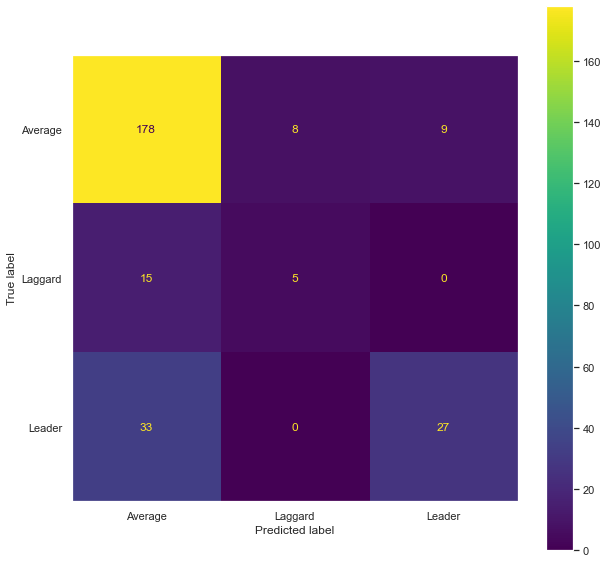

In [176]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [177]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        


In [178]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [179]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

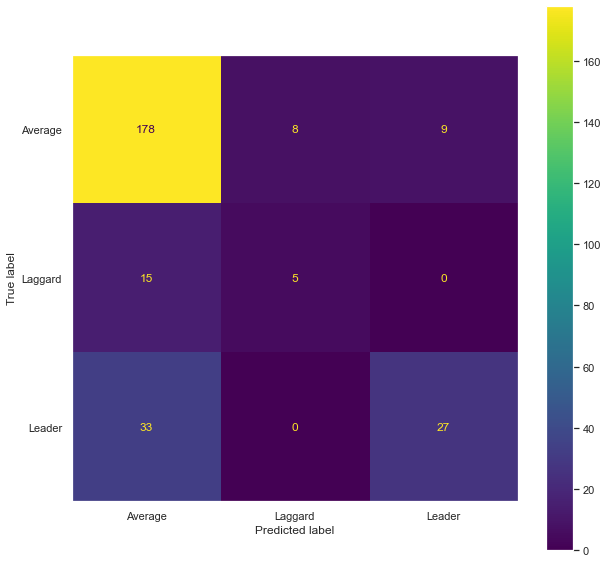

In [180]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [181]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        


look at total dataset (impact of increased data)

In [182]:
final_model_all_tot = xgb_final_all_model_pipe.fit(X, y2)

In [183]:
final_model_all_tot.score(X, y2)

0.9453551912568307

In [184]:
y_hat = final_model_all_tot.predict(X)

In [185]:
print(f"""
Our final model's accuracy on the overall dataset is {round(accuracy_score(y2, y_hat), 5)}. \n
Our final model's recall on the overall dataset is {round(recall_score(y2, y_hat, average='weighted'), 5)} \n
Our final model's precision on the overall dataset is {round(precision_score(y2, y_hat, average='weighted'), 5)} \n
Our final model's f1-score on the overall datasetoverall datasety_hat = final_model.predict(X_test) is {round(f1_score(y2, y_hat, average='weighted'), 5)}.
""")


Our final model's accuracy on the overall dataset is 0.94536. 

Our final model's recall on the overall dataset is 0.94536 

Our final model's precision on the overall dataset is 0.94665 

Our final model's f1-score on the overall datasetoverall datasety_hat = final_model.predict(X_test) is 0.94416.



# Advanced Model - no existing ESG Data 

In [186]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov',
       'classification'],
      dtype='object')

In [187]:
true_col = ['revenue', 'profit', 'num_of_employees', 'sector',
            'subsector', 'state', 'newcomer', 'ceo_founder',
            'ceo_woman', 'profitable', 'market_cap']


In [188]:
X3 = df[true_col]

In [189]:
y3 = df['classification']

In [190]:

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y, test_size=0.35, random_state=42)

dummy_model_3 = dummy_model_pipe.fit(X_train3, y_train3)

dtc_model_3 = dtc_model_pipe.fit(X_train3, y_train3)

knn_model_3 = knn_model_pipe.fit(X_train3, y_train3)

rfc_model_3 = rfc_model_pipe.fit(X_train3, y_train3)

gbc_model_3 = gbc_model_pipe.fit(X_train3, y_train3)

xgb_model_3 = xgb_model_pipe.fit(X_train3, y_train3)

ada_model_3 = ada_model_pipe.fit(X_train3, y_train3)

In [191]:
print(scoring(dummy_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(dtc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(knn_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(rfc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(gbc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(xgb_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(ada_model_3, X_train3, X_test3, y_train3, y_test3))

Test Data Results:
 accuracy - 0.5402597402597402 
 precision - 0.5400362062180245 
 recall - 0.5402597402597402 
 F1 Score - 0.5400431290099414 

CV Results for `train_model` model:
            0.54985 ± 0.04072 accuracy
        
Test Data Results:
 accuracy - 0.6441558441558441 
 precision - 0.6130334928229665 
 recall - 0.6441558441558441 
 F1 Score - 0.6242471409758287 

CV Results for `train_model` model:
            0.56523 ± 0.01890 accuracy
        
Test Data Results:
 accuracy - 0.6987012987012987 
 precision - 0.6108540870893813 
 recall - 0.6987012987012987 
 F1 Score - 0.6336692825361651 

CV Results for `train_model` model:
            0.67181 ± 0.01895 accuracy
        
Test Data Results:
 accuracy - 0.6987012987012987 
 precision - 0.6013952989159601 
 recall - 0.6987012987012987 
 F1 Score - 0.6171624601813281 

CV Results for `train_model` model:
            0.69426 ± 0.01194 accuracy
        
Test Data Results:
 accuracy - 0.6805194805194805 
 precision - 0.5893080783

# Attempting Scoring On E, S, and G Metrics

For the E, S, and G, companies can score from 1-10 in each respective category. The below modeling aims to classify whether a company's will score above or below the median E, S, and G score for public companies.

#### Building Target Variables

In [192]:
'environmental_score', 'social_score', 'governance_score'

('environmental_score', 'social_score', 'governance_score')

In [193]:
df.head()

company  rank       revenue        profit  num_of_employees  \
0      walmart     1  5.239640e+11  1.488100e+10           2200000   
1       amazon     2  2.805220e+11  1.158800e+10            798000   
3  exxon_mobil     3  2.649380e+11  1.434000e+10             74900   
5        apple     4  2.601740e+11  5.525600e+10            137000   
6   cvs_health     5  2.567760e+11  6.634000e+09            290000   

        sector                                subsector state newcomer  \
0    retailing               hypermarkets_super_centers    ar       no   
1    retailing         internet_direct_marketing_retail    wa       no   
3       energy                       integrated_oil_gas    tx       no   
5   technology  technology_hardware_storage_peripherals    ca       no   
6  health_care                     health_care_services    ri       no   

  ceo_founder  ...    profit_env    profit_soc    profit_gov   revenue_env  \
0          no  ...  1.190480e+10  6.101210e+09  4.910730e+09  4.191712e+11   
1         yes  ...  6.373400e+09  5.794000e+09  5.446360e+09  1.542871e+11   
3          no  ...  5.879400e+09  8.747400e+09  6.309600e+09  1.086246e+11   
5          no  ...  2.099728e+10  3.094336e+10  1.989216e+10  9.886612e+10   
6          no  ...  6.634000e+09  2.653600e+09  3.914060e+09  2.567760e+11   

    revenue_soc   revenue_gov    marcap_env    marcap_soc    marcap_gov  \
0  2.148252e+11  1.729081e+11  3.293520e+11  1.687929e+11  1.358577e+11   
1  1.402610e+11  1.318453e+11  9.005728e+11  8.187025e+11  7.695804e+11   
3  1.616122e+11  1.165727e+11  7.294843e+10  1.085330e+11  7.828612e+10   
5  1.456974e+11  9.366264e+10  8.440469e+11  1.243859e+12  7.996234e+11   
6  1.027104e+11  1.514978e+11  9.849600e+10  3.939840e+10  5.811264e+10   

   classification  
0         Average  
1         Average  
3         Average  
5         Average  
6         Average  

[5 rows x 31 columns]

In [194]:
median_e = df.environmental_score.median()
median_s = df.social_score.median()
median_g = df.governance_score.median()

In [195]:
df['env_class'] = df['environmental_score'] > median_e
df['soc_class'] = df['social_score'] > median_s
df['gov_class'] = df['governance_score'] > median_g

In [196]:
df.head()

company  rank       revenue        profit  num_of_employees  \
0      walmart     1  5.239640e+11  1.488100e+10           2200000   
1       amazon     2  2.805220e+11  1.158800e+10            798000   
3  exxon_mobil     3  2.649380e+11  1.434000e+10             74900   
5        apple     4  2.601740e+11  5.525600e+10            137000   
6   cvs_health     5  2.567760e+11  6.634000e+09            290000   

        sector                                subsector state newcomer  \
0    retailing               hypermarkets_super_centers    ar       no   
1    retailing         internet_direct_marketing_retail    wa       no   
3       energy                       integrated_oil_gas    tx       no   
5   technology  technology_hardware_storage_peripherals    ca       no   
6  health_care                     health_care_services    ri       no   

  ceo_founder  ...   revenue_env   revenue_soc   revenue_gov    marcap_env  \
0          no  ...  4.191712e+11  2.148252e+11  1.729081e+11  3.293520e+11   
1         yes  ...  1.542871e+11  1.402610e+11  1.318453e+11  9.005728e+11   
3          no  ...  1.086246e+11  1.616122e+11  1.165727e+11  7.294843e+10   
5          no  ...  9.886612e+10  1.456974e+11  9.366264e+10  8.440469e+11   
6          no  ...  2.567760e+11  1.027104e+11  1.514978e+11  9.849600e+10   

     marcap_soc    marcap_gov  classification  env_class  soc_class  gov_class  
0  1.687929e+11  1.358577e+11         Average       True      False      False  
1  8.187025e+11  7.695804e+11         Average       True       True      False  
3  1.085330e+11  7.828612e+10         Average      False       True      False  
5  1.243859e+12  7.996234e+11         Average      False       True      False  
6  3.939840e+10  5.811264e+10         Average       True      False       True  

[5 rows x 34 columns]

In [197]:
df['env_class'].value_counts()

False    557
True     541
Name: env_class, dtype: int64

In [198]:
df['soc_class'].value_counts()

False    561
True     537
Name: soc_class, dtype: int64

In [199]:
df['gov_class'].value_counts()

False    584
True     514
Name: gov_class, dtype: int64

### ENV Rating First

In [200]:
Xe = df[true_col]

In [201]:
ye = df['env_class']

In [202]:

X_traine, X_teste, y_traine, y_teste = train_test_split(Xe, ye, stratify=y, test_size=0.35, random_state=42)

dummy_model_e = dummy_model_pipe.fit(X_traine, y_traine)

dtc_model_e = dtc_model_pipe.fit(X_traine, y_traine)

knn_model_e = knn_model_pipe.fit(X_traine, y_traine)

rfc_model_e = rfc_model_pipe.fit(X_traine, y_traine)

gbc_model_e = gbc_model_pipe.fit(X_traine, y_traine)

xgb_model_e = xgb_model_pipe.fit(X_traine, y_traine)

ada_model_e = ada_model_pipe.fit(X_traine, y_traine)

In [203]:
print(scoring(dummy_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(dtc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(knn_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(rfc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(gbc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(xgb_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(ada_model_e, X_traine, X_teste, y_traine, y_teste))

Test Data Results:
 accuracy - 0.4883116883116883 
 precision - 0.48853672643146323 
 recall - 0.4883116883116883 
 F1 Score - 0.48839457462779384 

CV Results for `train_model` model:
            0.50904 ± 0.03953 accuracy
        
Test Data Results:
 accuracy - 0.6233766233766234 
 precision - 0.6234358847762023 
 recall - 0.6233766233766234 
 F1 Score - 0.6234020494273659 

CV Results for `train_model` model:
            0.67189 ± 0.03547 accuracy
        
Test Data Results:
 accuracy - 0.6753246753246753 
 precision - 0.6758938691793445 
 recall - 0.6753246753246753 
 F1 Score - 0.6753860137662742 

CV Results for `train_model` model:
            0.72922 ± 0.05892 accuracy
        
Test Data Results:
 accuracy - 0.7246753246753247 
 precision - 0.7256908336290557 
 recall - 0.7246753246753247 
 F1 Score - 0.7246938995805575 

CV Results for `train_model` model:
            0.74193 ± 0.02863 accuracy
        
Test Data Results:
 accuracy - 0.7168831168831169 
 precision - 0.71805449

### SOC Rating

In [204]:
X_s = df[true_col]

y_s = df['soc_class']


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, stratify=y, test_size=0.35, random_state=42)

dummy_model__s = dummy_model_pipe.fit(X_train_s, y_train_s)

dtc_model__s = dtc_model_pipe.fit(X_train_s, y_train_s)

knn_model__s = knn_model_pipe.fit(X_train_s, y_train_s)

rfc_model__s = rfc_model_pipe.fit(X_train_s, y_train_s)

gbc_model__s = gbc_model_pipe.fit(X_train_s, y_train_s)

xgb_model__s = xgb_model_pipe.fit(X_train_s, y_train_s)

ada_model__s = ada_model_pipe.fit(X_train_s, y_train_s)

print(scoring(dummy_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(dtc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(knn_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(rfc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(gbc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(xgb_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(ada_model__s, X_train_s, X_test_s, y_train_s, y_test_s))

Test Data Results:
 accuracy - 0.4961038961038961 
 precision - 0.49951940173287934 
 recall - 0.4961038961038961 
 F1 Score - 0.4947765640098271 

CV Results for `train_model` model:
            0.54289 ± 0.03762 accuracy
        
Test Data Results:
 accuracy - 0.5688311688311688 
 precision - 0.5680204090728687 
 recall - 0.5688311688311688 
 F1 Score - 0.5680418892275486 

CV Results for `train_model` model:
            0.56373 ± 0.03855 accuracy
        
Test Data Results:
 accuracy - 0.5896103896103896 
 precision - 0.5894312583967756 
 recall - 0.5896103896103896 
 F1 Score - 0.5895049223891944 

CV Results for `train_model` model:
            0.61993 ± 0.02631 accuracy
        
Test Data Results:
 accuracy - 0.6519480519480519 
 precision - 0.6515561139846154 
 recall - 0.6519480519480519 
 F1 Score - 0.6513109226294669 

CV Results for `train_model` model:
            0.62971 ± 0.01557 accuracy
        
Test Data Results:
 accuracy - 0.6675324675324675 
 precision - 0.669823016

### GOV Rating

In [205]:
X_g = df[true_col]

y_g = df['gov_class']


X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, stratify=y, test_size=0.35, random_state=42)

dummy_model__g = dummy_model_pipe.fit(X_train_g, y_train_g)

dtc_model__g = dtc_model_pipe.fit(X_train_g, y_train_g)

knn_model__g = knn_model_pipe.fit(X_train_g, y_train_g)

rfc_model__g = rfc_model_pipe.fit(X_train_g, y_train_g)

gbc_model__g = gbc_model_pipe.fit(X_train_g, y_train_g)

xgb_model__g = xgb_model_pipe.fit(X_train_g, y_train_g)

ada_model__g = ada_model_pipe.fit(X_train_g, y_train_g)

print(scoring(dummy_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(dtc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(knn_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(rfc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(gbc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(xgb_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(ada_model__g, X_train_g, X_test_g, y_train_g, y_test_g))

Test Data Results:
 accuracy - 0.5246753246753246 
 precision - 0.5280675492185576 
 recall - 0.5246753246753246 
 F1 Score - 0.5233716489213723 

CV Results for `train_model` model:
            0.51340 ± 0.03667 accuracy
        
Test Data Results:
 accuracy - 0.5818181818181818 
 precision - 0.5830167564861443 
 recall - 0.5818181818181818 
 F1 Score - 0.5819423308239776 

CV Results for `train_model` model:
            0.58904 ± 0.03540 accuracy
        
Test Data Results:
 accuracy - 0.5584415584415584 
 precision - 0.5625988238847336 
 recall - 0.5584415584415584 
 F1 Score - 0.557098982098982 

CV Results for `train_model` model:
            0.59738 ± 0.05132 accuracy
        
Test Data Results:
 accuracy - 0.5792207792207792 
 precision - 0.5900064127912229 
 recall - 0.5792207792207792 
 F1 Score - 0.5737080373458866 

CV Results for `train_model` model:
            0.61569 ± 0.01988 accuracy
        
Test Data Results:
 accuracy - 0.548051948051948 
 precision - 0.568991246986

## New GridSearch for RFC (New Best Model)

In [206]:
# params = {}
# params['rfc__n_estimators'] = [10, 50, 100]
# params['rfc__criterion'] = ['gini', 'entropy', 'log_loss']
# params['rfc__max_depth'] = [1,3,5,11]
# params['rfc__min_samples_split'] = [2,3,5]
# params['rfc__min_samples_leaf'] = [1,3,5]

In [207]:
# params

{'rfc__n_estimators': [10, 50, 100],
 'rfc__criterion': ['gini', 'entropy', 'log_loss'],
 'rfc__max_depth': [1, 3, 5, 11],
 'rfc__min_samples_split': [2, 3, 5],
 'rfc__min_samples_leaf': [1, 3, 5]}

In [208]:
# gs2 = GridSearchCV(rfc_model_pipe,params, cv=10, verbose=1)

In [209]:
# gs2.fit(X_train3, y_train3)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/en

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __cal

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd063cd4190>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(missing_values=None,
                                                                                

In [210]:
# gs2.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 11,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 3,
 'rfc__n_estimators': 10}

In [211]:
# gs2.score(X_train3, y_train3)

0.7391304347826086

In [212]:
# gs2.cv_results_['mean_test_score'].mean()

nan

In [213]:
# gs2.score(X_test3, y_test3)

0.7012987012987013

# Final Model - all features

In [214]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [215]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

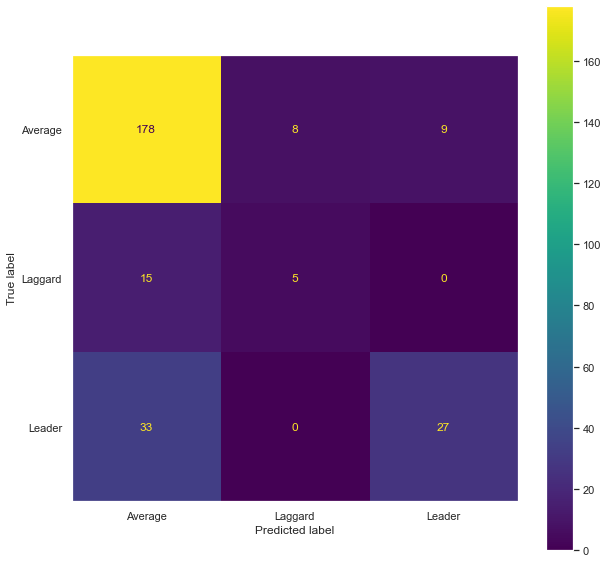

In [216]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [217]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        
